In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy
from sklearn.model_selection import KFold


In [2]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [3]:
def norm(x, *par):
    return par[0]*np.exp(par[1]*x**2)

In [4]:
def poly(x, *par):
    return np.polyval(par,x)

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def const(x, *par):
    return 0

In [7]:
def recip(x, *par):
    return 1/(par[0]*x**2+1)

In [8]:
def gp(x_train, y_train, kernel, mean_function, init_params):
    res = scipy.optimize.curve_fit(
        mean_function,  np.ravel(x_train), np.ravel(y_train), p0=init_params, maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_function(x, *par)
    mf.update_gradients = lambda a,b: None
    
    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()
    return model

In [9]:
def draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, subplot, ylim=False):
    subplot.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    subplot.scatter(x_train, y_train, marker="x", color='black', label="train")
    subplot.scatter(x_val, y_val, marker="x", color='red', label="validate")
    subplot.scatter(x_test, y_test, marker="x", color='blue', label="test")
    subplot.plot(domain, y_mean, label="mean")
    if ylim:
        subplot.set_ylim(ylim)       
    subplot.grid(True)
    subplot.legend()


In [10]:
def cwgp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    model_holder = kwargs["model_holder"]
    ylim = kwargs["ylim"]
    
    cwgp_y_train = y_train
    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp_model in model_holder:
        cwgp_y_train, y_d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_train)
        
        cwgp_y_val, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_val)
        
        cwgp_y_test, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_test)
        
    model = gp(x_train, cwgp_y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )

    start, end = 1940, 2031
    domain_discrete = np.arange(start, end+1).reshape(-1,1)
    domain = np.linspace(start,end,end-start+1)
    cwgp_y_all = model.predict(domain_discrete)
    cwgp_y_mean, cwgp_y_var = cwgp_y_all[0], cwgp_y_all[1]
    cwgp_y_top, cwgp_y_bot = cwgp_y_mean + 1.96*np.sqrt(cwgp_y_var), cwgp_y_mean - 1.96*np.sqrt(cwgp_y_var)
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    
    y_mean, y_var, y_top, y_bot = cwgp_y_mean, cwgp_y_var, cwgp_y_top, cwgp_y_bot
    
    for cwgp_model in model_holder[::-1]:
        y_mean, y_var = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_var)
        y_top, y_bot = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_top), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_bot)
        predict_y_val_mean, predict_y_test_mean = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_val_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_test_mean)
        
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
        
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
    
    draw(domain, cwgp_y_mean, cwgp_y_top, cwgp_y_bot, x_train, cwgp_y_train, x_val, 
         cwgp_y_val, x_test, cwgp_y_test, ax1)
    draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, ax2, ylim=ylim)

    print(kwargs["hyperparams"])
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    plt.show()
    return validate_rmse, test_rmse

In [11]:
def gp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    ylim = kwargs["ylim"]
    
    model = gp(x_train, y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )
    
    start, end = 1940, 2031
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    
    model.plot(plot_limits=[start,end])
    plt.ylim(ylim)
    plt.grid(True)
    plt.scatter(x_train, y_train, marker="x", color='black', label="train")
    plt.scatter(x_val, y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.show()
    

In [12]:
CSV_FIlE = "../japan.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
age_lim = [0.1,0.35]
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["total"].to_numpy().reshape(-1,1)

val_rmse_list, test_rmse_list = [],[]

In [13]:
test_ratio = 1 - 0.15
length = len(rate)

test = int(test_ratio*length)

x_tv, y_tv = year[:test], rate[:test]
x_test, y_test = year[test:], rate[test:]

params:[-3.20013556e-03  6.55923448e+00]
validate_rmse: 0.016610576040442235 
 test_rmse: 0.01622584514145952



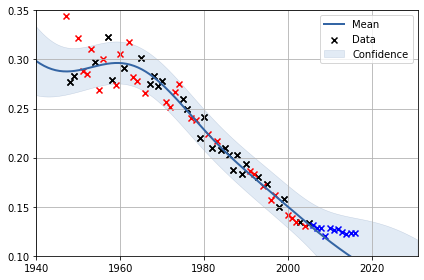

params:[-3.37741188e-03  6.90809948e+00]
validate_rmse: 0.016353879027227736 
 test_rmse: 0.013302274511735589



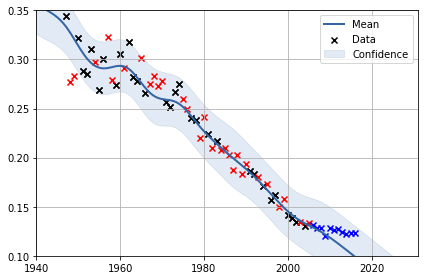

In [14]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=age_lim,
                         mean_func=poly, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

params:[-4.01399997e-03  8.17498952e+00]
validate_rmse: 0.03103624204869363 
 test_rmse: 0.025399200582693494



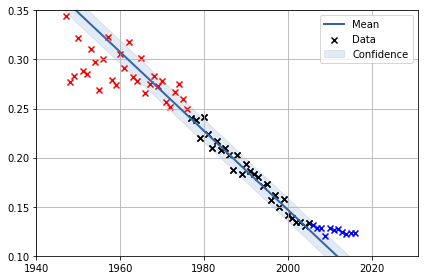

params:[-1.63670891e-03  3.49596503e+00]
validate_rmse: 0.05800617324689194 
 test_rmse: 0.07886226613137744



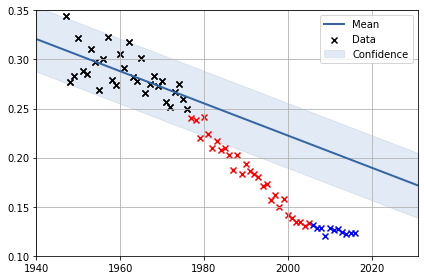

In [15]:
kf = KFold(n_splits=2)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=age_lim,
                         mean_func=poly, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

  0%|          | 0/64 [00:00<?, ?it/s]

[('box_cox', 1), ('sa', 1)]
params:[-1.46023987e-02  2.24886413e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.016927320605541658 
 test_rmse: 0.007871656055257878



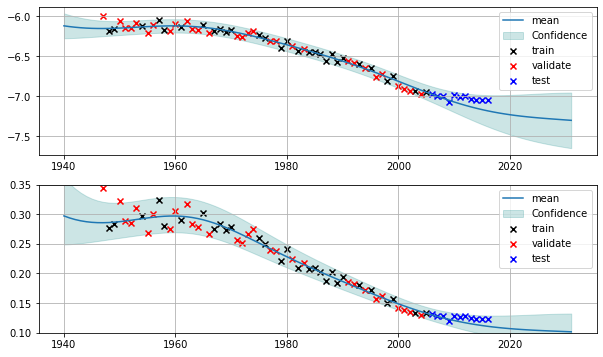

params:[-1.52055831e-02  2.36645446e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01491242340616062 
 test_rmse: 0.005661792169634198



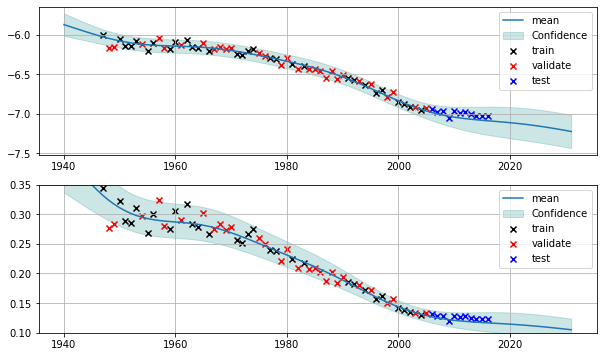

  2%|▏         | 1/64 [00:01<01:07,  1.07s/it]

params:[-7.47274452e-02  1.48404975e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016793542411807454 
 test_rmse: 0.003535508106643123



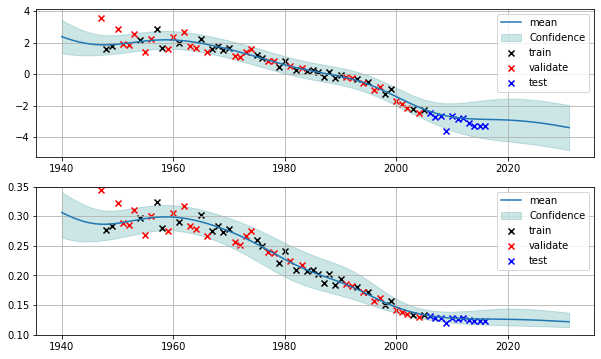

params:[-7.39931722e-02  1.46726578e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016552129340875285 
 test_rmse: 0.006634671565042129



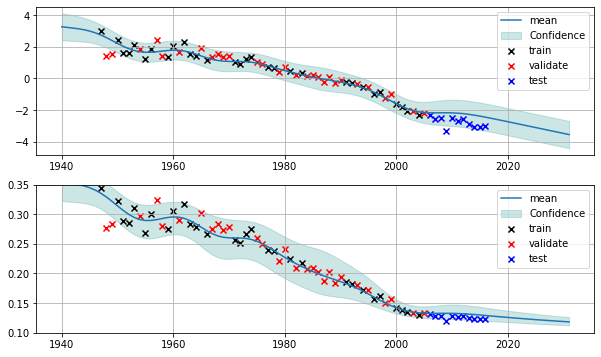

  3%|▎         | 2/64 [00:02<01:12,  1.17s/it]

params:[-7.40260851e-02  1.46006516e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01677279258956122 
 test_rmse: 0.0037510683974884287



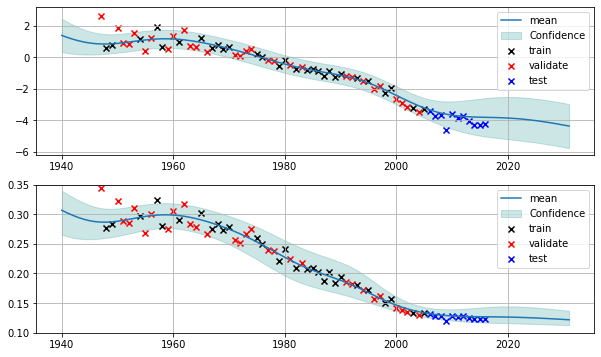

params:[-6.82840131e-02  1.34610301e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01734633902478511 
 test_rmse: 0.008321537204013947



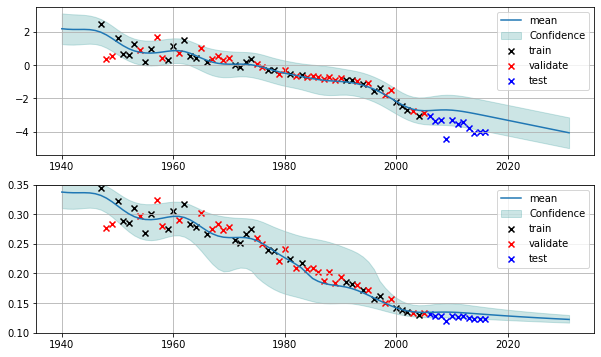

  5%|▍         | 3/64 [00:03<01:10,  1.15s/it]

params:[-7.46106651e-02  1.48147628e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016775043068056505 
 test_rmse: 0.003481105310897939



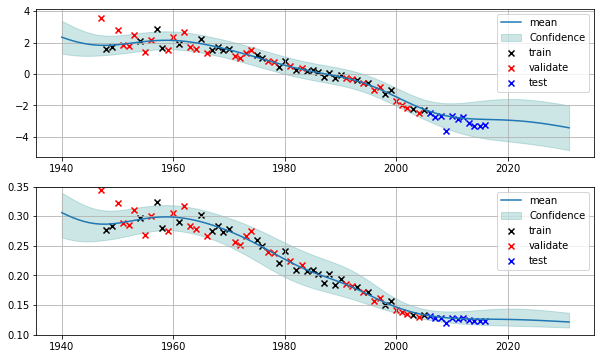

params:[-7.38288204e-02  1.46375355e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01654774742103825 
 test_rmse: 0.00658177918310418



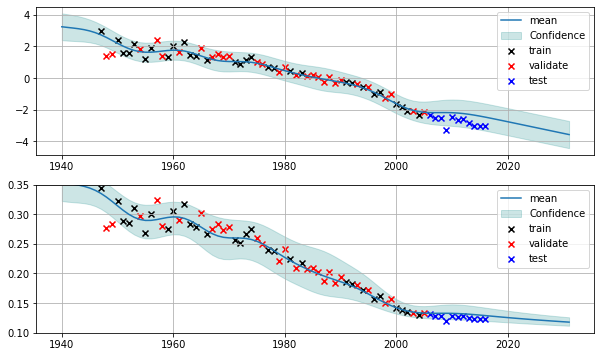

  6%|▋         | 4/64 [00:04<01:09,  1.16s/it]

params:[-7.41550140e-02  1.45209473e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.016758570898888294 
 test_rmse: 0.003390097479890549



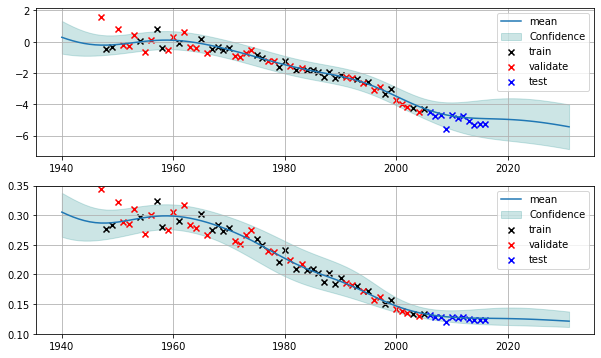

params:[-7.03115839e-02  1.37485148e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.017322566682407198 
 test_rmse: 0.0076576901995230925



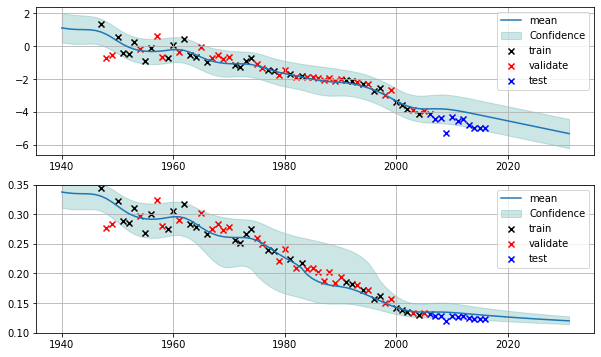

  8%|▊         | 5/64 [00:05<01:05,  1.11s/it]

params:[-7.31774366e-02  1.44667090e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016231778920564894 
 test_rmse: 0.00390005928410821



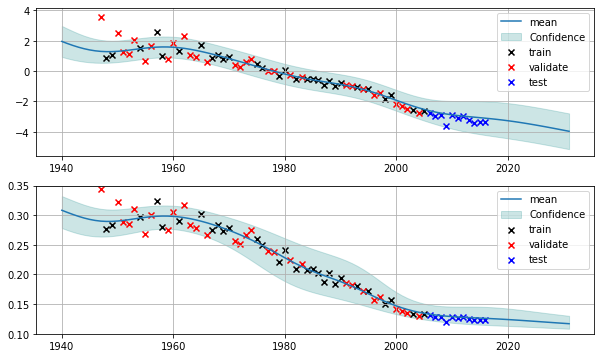

params:[-6.28558828e-02  1.24033577e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01798229770353782 
 test_rmse: 0.00801771099045236



 /home/chen/work/venv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/chen/work/venv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/chen/work/venv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


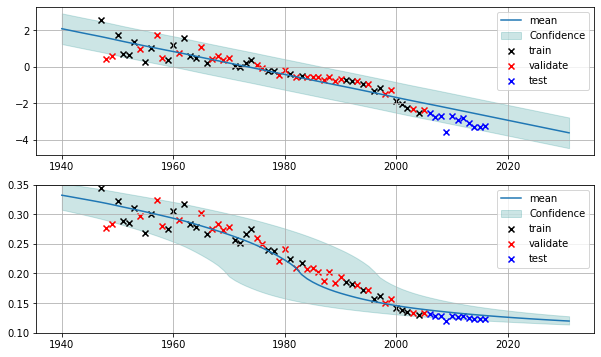

  9%|▉         | 6/64 [00:06<01:05,  1.13s/it]

params:[-7.45917256e-02  1.47060466e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016744516763167443 
 test_rmse: 0.003287890130102487



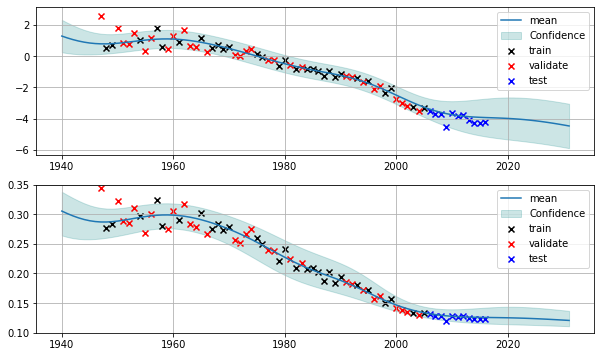

params:[-6.78307035e-02  1.33662659e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01740601193253226 
 test_rmse: 0.00827566025097452



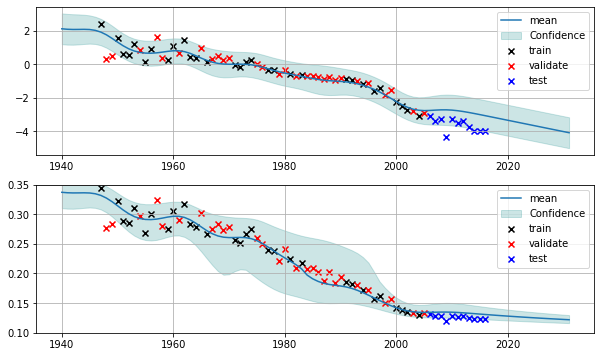

 11%|█         | 7/64 [00:07<01:03,  1.12s/it]

params:[-7.44012312e-02  1.47688378e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016743066949275416 
 test_rmse: 0.0033913616039472705



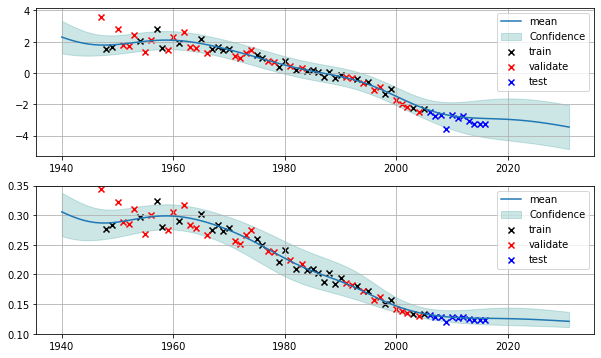

params:[-7.35280992e-02  1.45735881e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016542624155467322 
 test_rmse: 0.006483738663196305



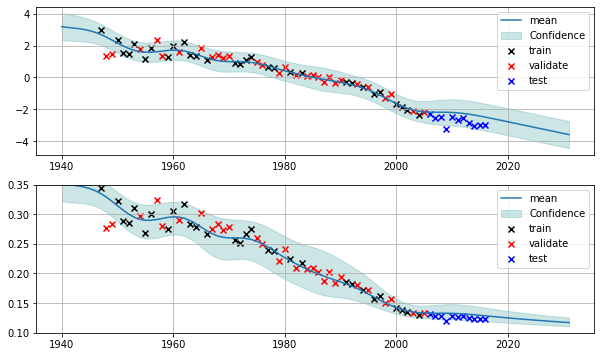

 12%|█▎        | 8/64 [00:08<01:01,  1.11s/it]

params:[-7.48289052e-02  1.45181612e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.016366678029595596 
 test_rmse: 0.0027801193184827495



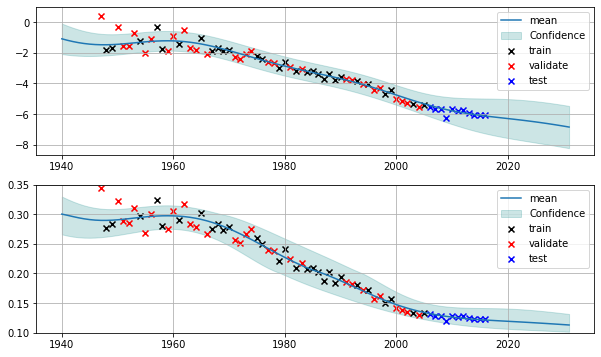

params:[-7.05342443e-02  1.36632551e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01618518091032655 
 test_rmse: 0.005785507069844736



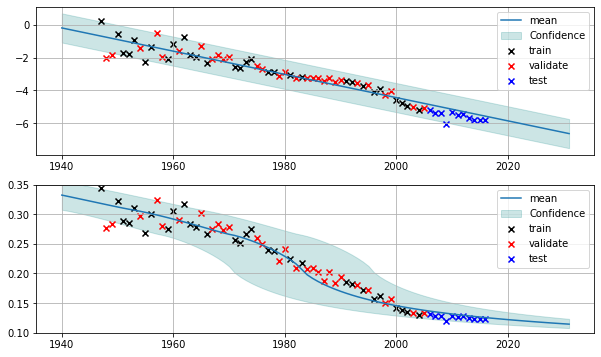

 14%|█▍        | 9/64 [00:10<01:00,  1.10s/it]

params:[-6.55773953e-02  1.29102478e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014767999458293646 
 test_rmse: 0.009283666213825871



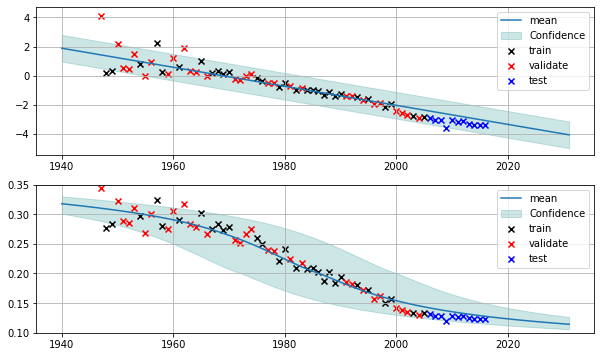

params:[-6.02206234e-02  1.18085198e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016140517022085066 
 test_rmse: 0.004924077801012298



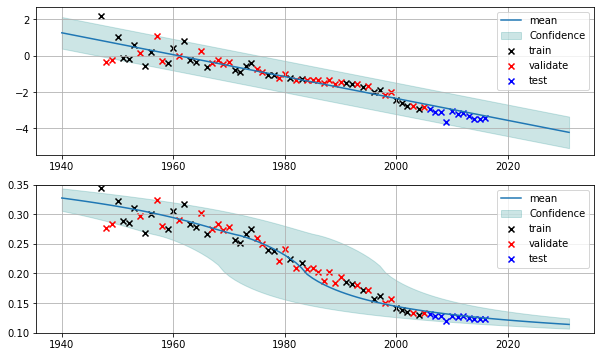

 16%|█▌        | 10/64 [00:11<00:59,  1.09s/it]

params:[-7.38546353e-02  1.44963577e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.014766488035989891 
 test_rmse: 0.009370223577852705



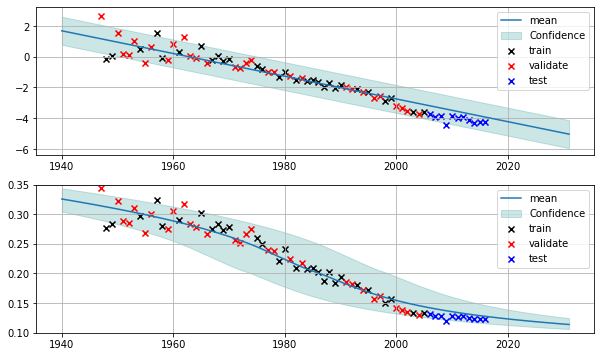

params:[-6.60439670e-02  1.29154944e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016889926669746924 
 test_rmse: 0.006527165243571595



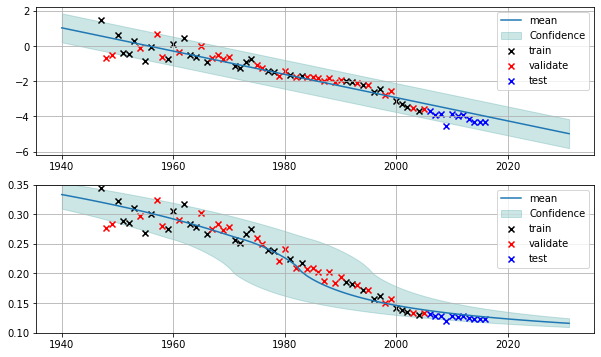

 17%|█▋        | 11/64 [00:12<00:58,  1.10s/it]

params:[-7.50105697e-02  1.48220760e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014721564827655938 
 test_rmse: 0.008749428176196969



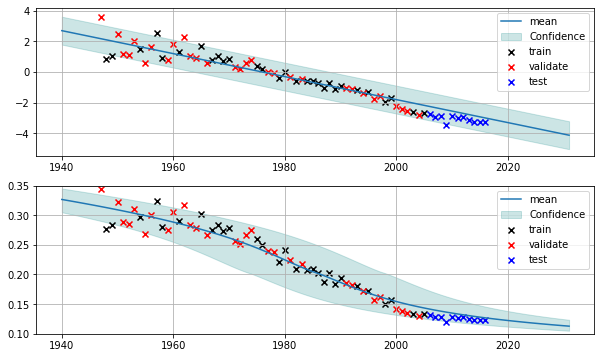

params:[-6.25567675e-02  1.23366009e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.017983260574173 
 test_rmse: 0.00783898162810488



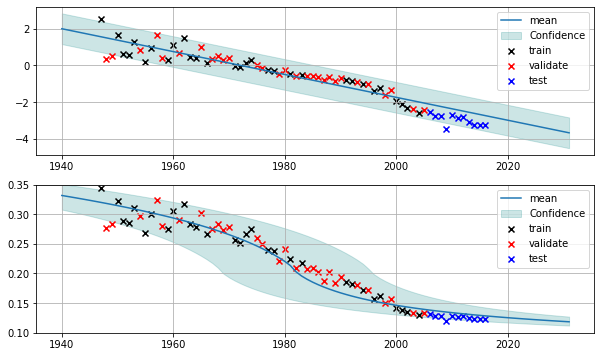

 19%|█▉        | 12/64 [00:13<00:57,  1.10s/it]

params:[-7.80135217e-02  1.52668587e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01675189378141877 
 test_rmse: 0.012726930579836725



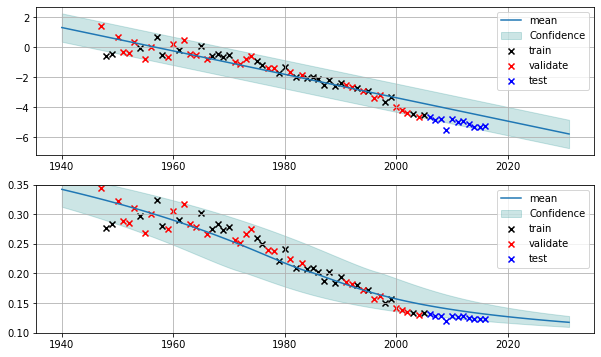

params:[-7.20399299e-02  1.40725587e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.017555132931469306 
 test_rmse: 0.007214910199560751



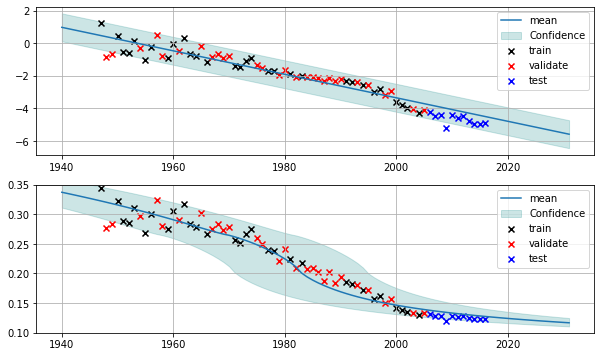

 20%|██        | 13/64 [00:14<00:54,  1.06s/it]

params:[-7.50106238e-02  1.48220866e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01472157084970504 
 test_rmse: 0.008749412768760383



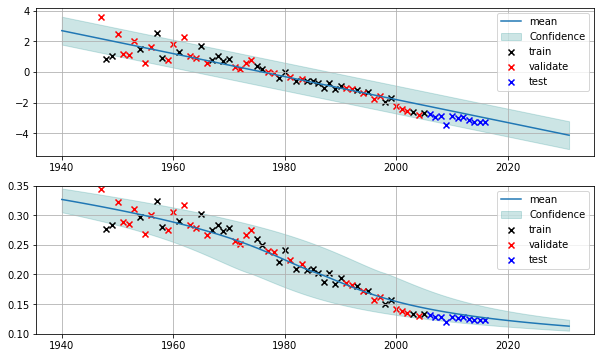

params:[-6.25567361e-02  1.23365947e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.017983261916485086 
 test_rmse: 0.007838982859050846



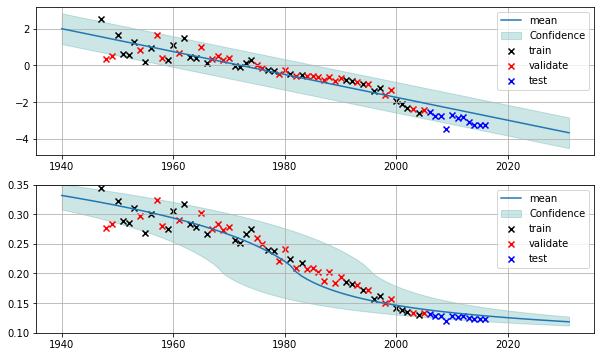

 22%|██▏       | 14/64 [00:15<00:52,  1.05s/it]

params:[-7.77753323e-02  1.53205265e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016836169354402013 
 test_rmse: 0.012923099479423248



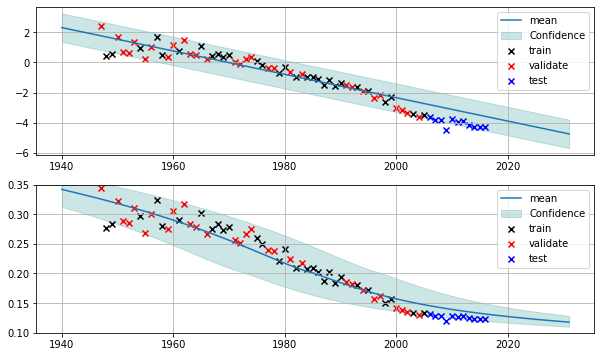

params:[-6.73165407e-02  1.32555786e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01984553259417569 
 test_rmse: 0.009401512535525437



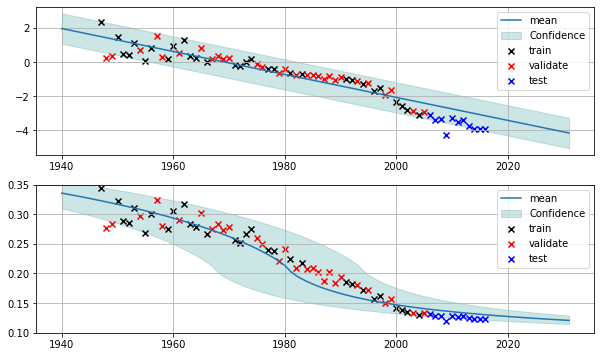

 23%|██▎       | 15/64 [00:16<00:52,  1.07s/it]

params:[-7.40377897e-02  1.46897223e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01589504400621512 
 test_rmse: 0.013316432717538844



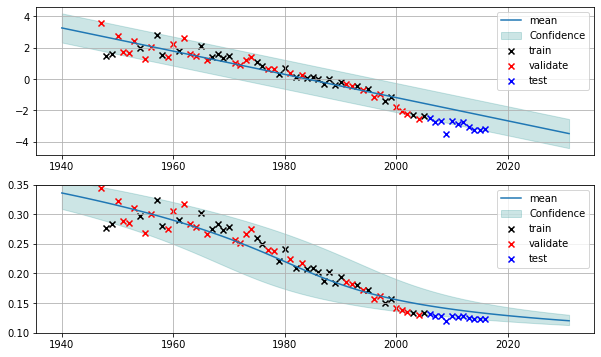

params:[-7.29967748e-02  1.44612803e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01994300625484371 
 test_rmse: 0.008501818333557442



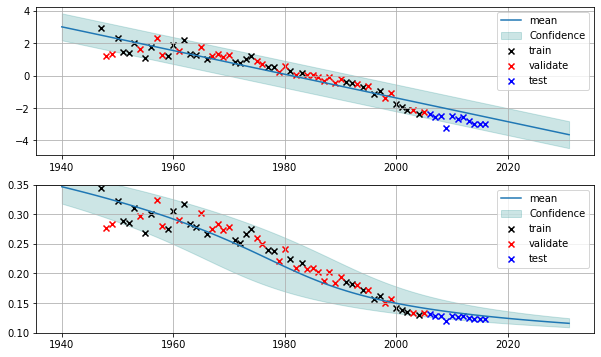

 25%|██▌       | 16/64 [00:17<00:53,  1.11s/it]

params:[-6.46341767e-02  1.23718815e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014928322658500545 
 test_rmse: 0.006846723313082603



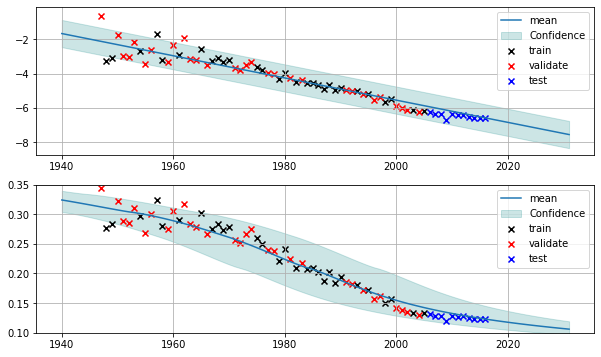

params:[-6.07851239e-02  1.16094387e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015193807929055187 
 test_rmse: 0.003934566500145012



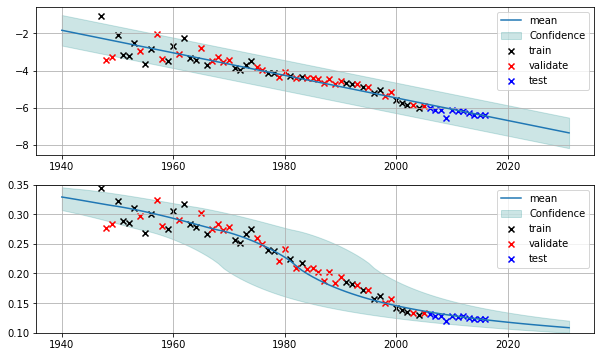

 27%|██▋       | 17/64 [00:18<00:50,  1.07s/it]

params:[-6.05589139e-02  1.18825863e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.015134107274710169 
 test_rmse: 0.00915632325490033



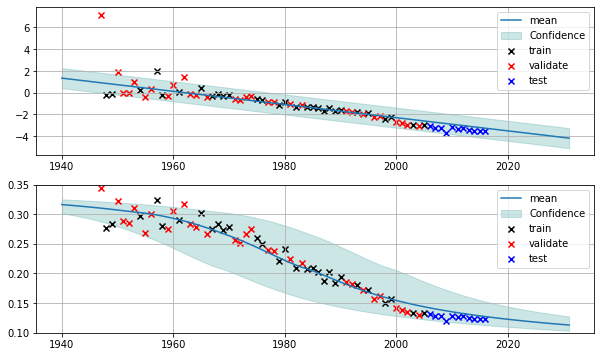

params:[-5.52265173e-02  1.07865195e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016560569590587795 
 test_rmse: 0.004750199300749179



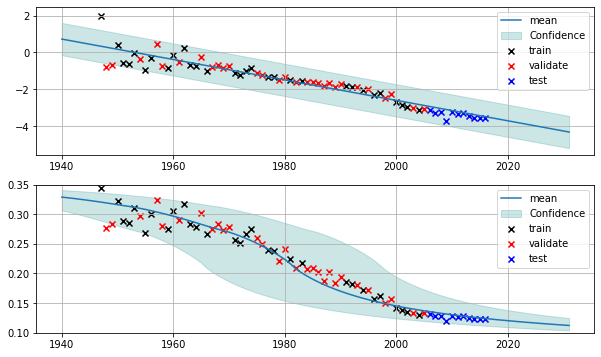

 28%|██▊       | 18/64 [00:19<00:49,  1.08s/it]

params:[-6.84215019e-02  1.33514153e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.014295178408155208 
 test_rmse: 0.005935349812387475



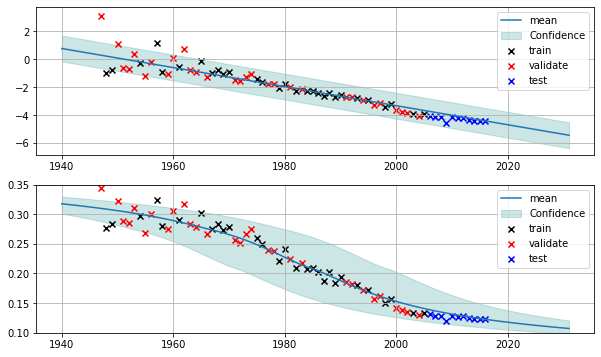

params:[-5.91621921e-02  1.15019285e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.017133880121896743 
 test_rmse: 0.005903142065868857



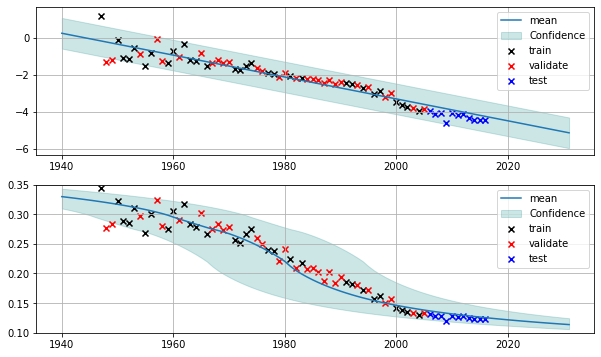

 30%|██▉       | 19/64 [00:20<00:48,  1.08s/it]

params:[-6.59793998e-02  1.29787056e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014765254171540594 
 test_rmse: 0.00797152408872811



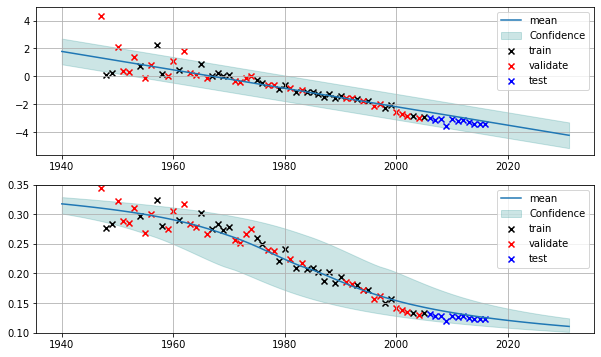

params:[-5.96710595e-02  1.16907175e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01581914128294483 
 test_rmse: 0.0044557068224198625



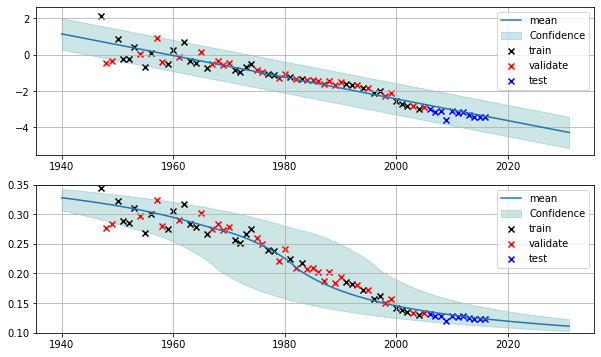

 31%|███▏      | 20/64 [00:22<00:50,  1.14s/it]

params:[-7.03537610e-02  1.36982254e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015064771536840096 
 test_rmse: 0.010146335994048883



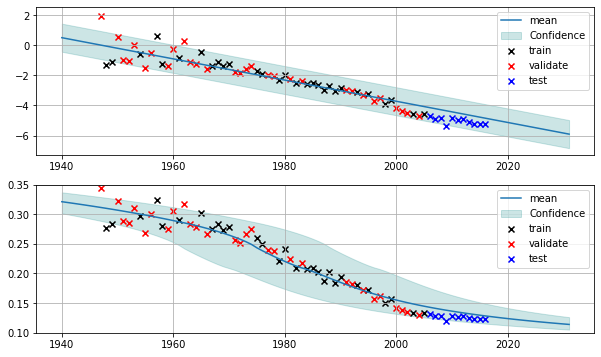

params:[-6.62882689e-02  1.28470786e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015701191407576247 
 test_rmse: 0.004897080746526336



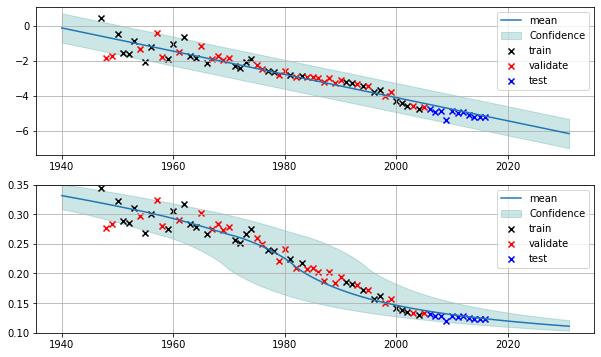

 33%|███▎      | 21/64 [00:23<00:49,  1.15s/it]

params:[-6.40998333e-02  1.26009803e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014690086669343317 
 test_rmse: 0.008698643738007467



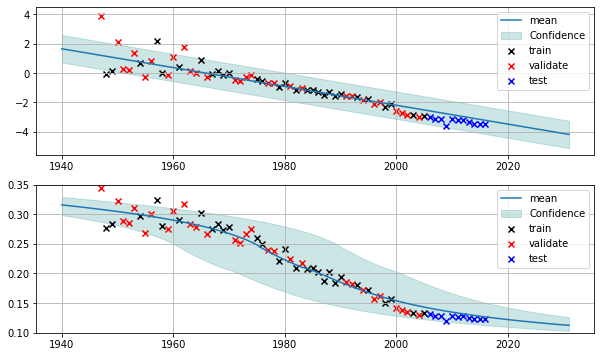

params:[-6.05312543e-02  1.18602041e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.015365918637516105 
 test_rmse: 0.003993082607226516



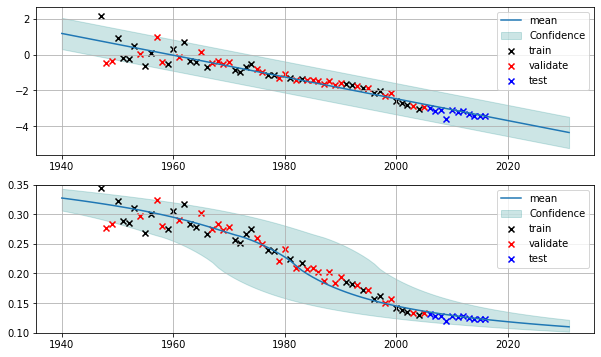

 34%|███▍      | 22/64 [00:24<00:47,  1.14s/it]

params:[-7.03077151e-02  1.37923736e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015250827556568682 
 test_rmse: 0.01068592600882823



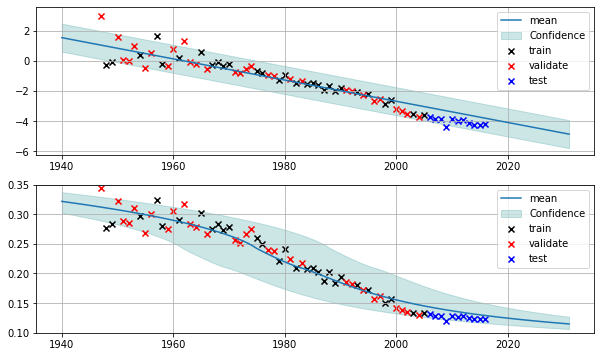

params:[-6.66439837e-02  1.30218206e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016219699266684113 
 test_rmse: 0.005440377121398739



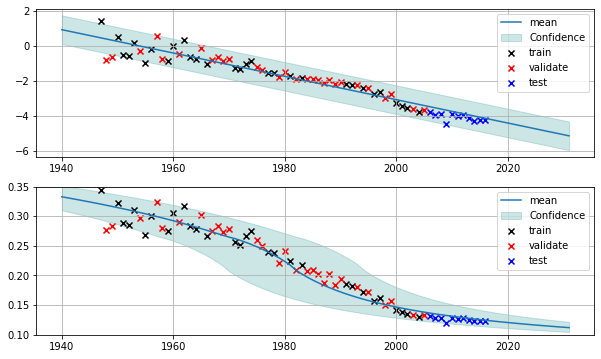

 36%|███▌      | 23/64 [00:25<00:46,  1.13s/it]

params:[-7.48096746e-02  1.47705458e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014778878315334242 
 test_rmse: 0.007713620700309191



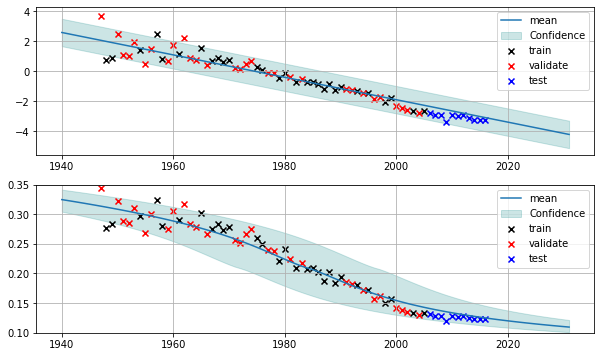

params:[-6.31640137e-02  1.24454160e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.0175131562496152 
 test_rmse: 0.007044233487494524



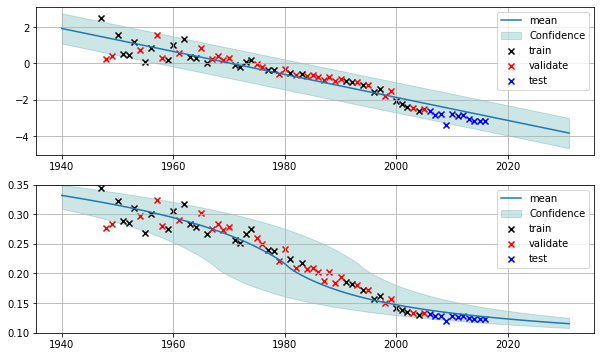

 38%|███▊      | 24/64 [00:26<00:46,  1.17s/it]

params:[-7.56934638e-02  1.46728006e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01533585339951629 
 test_rmse: 0.008588663357150516



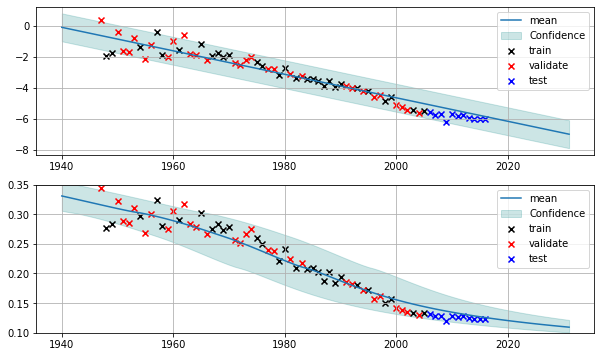

params:[-6.92040519e-02  1.33857424e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015937033975853013 
 test_rmse: 0.005334168728662984



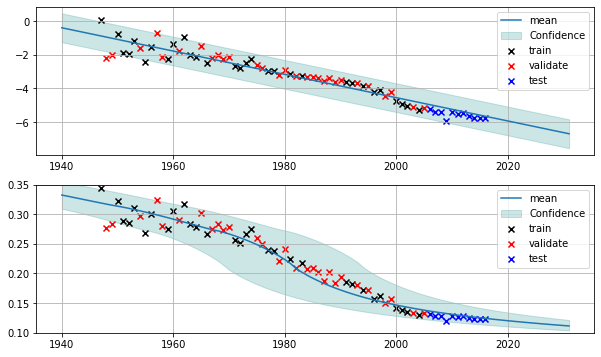

 39%|███▉      | 25/64 [00:27<00:44,  1.13s/it]

params:[-6.59793690e-02  1.29786994e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014765245434091108 
 test_rmse: 0.007971533683075753



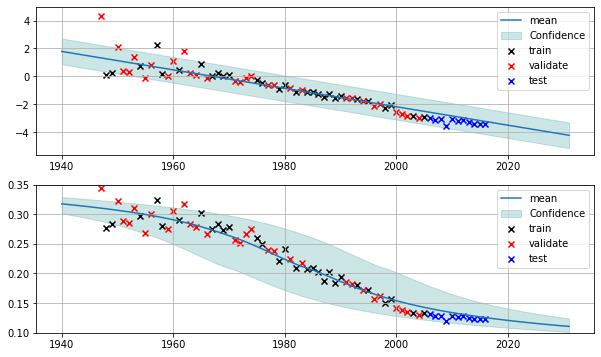

params:[-5.96711112e-02  1.16907278e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01581912895158225 
 test_rmse: 0.004455701833401397



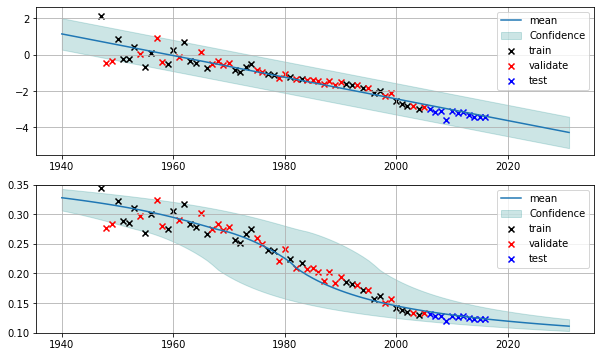

 41%|████      | 26/64 [00:28<00:42,  1.12s/it]

params:[-7.03077602e-02  1.37923826e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015250832225881363 
 test_rmse: 0.010685909336062727



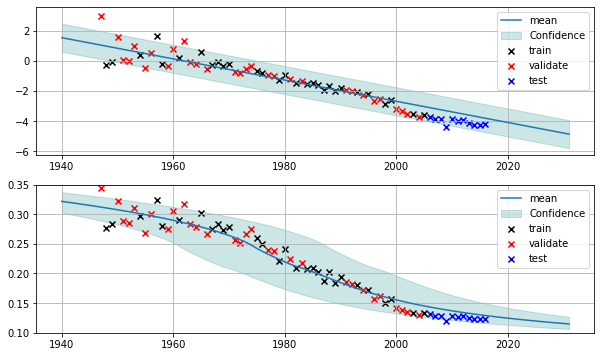

params:[-6.66439852e-02  1.30218208e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01621970298717537 
 test_rmse: 0.005440378412397657



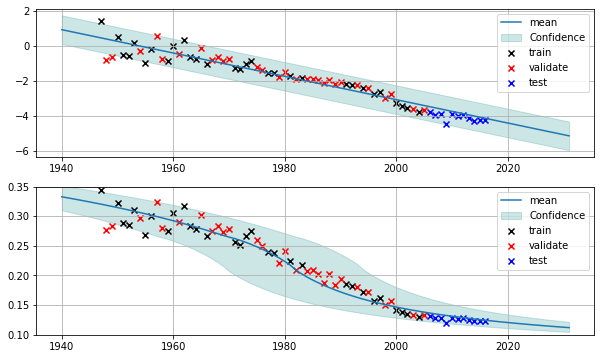

 42%|████▏     | 27/64 [00:30<00:41,  1.11s/it]

params:[-7.48095002e-02  1.47705113e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014778868451702492 
 test_rmse: 0.00771371249790309



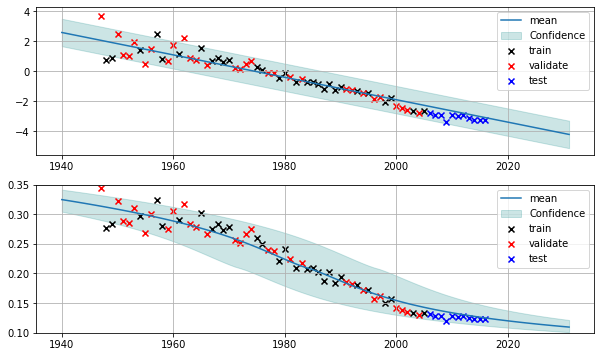

params:[-6.31639861e-02  1.24454107e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.017513146867905942 
 test_rmse: 0.0070442245260150605



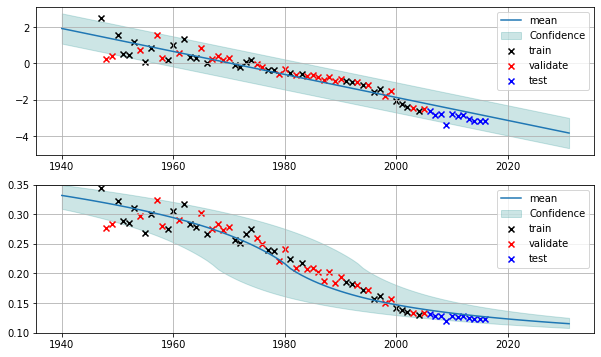

 44%|████▍     | 28/64 [00:31<00:39,  1.11s/it]

params:[-7.99335499e-02  1.56293341e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01649625884939125 
 test_rmse: 0.011026970782393265



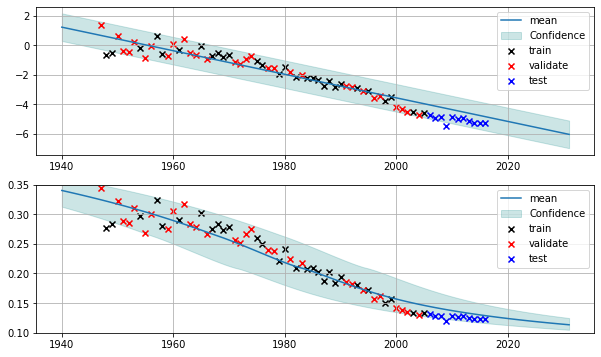

params:[-7.11441436e-02  1.38791595e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.017165724905529513 
 test_rmse: 0.006570986430705031



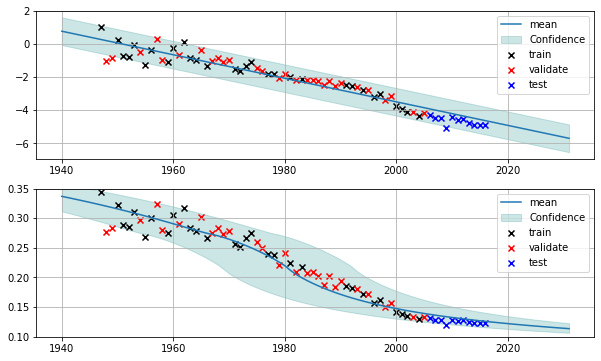

 45%|████▌     | 29/64 [00:32<00:38,  1.09s/it]

params:[-7.48095605e-02  1.47705232e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014778872530021078 
 test_rmse: 0.007713684671759223



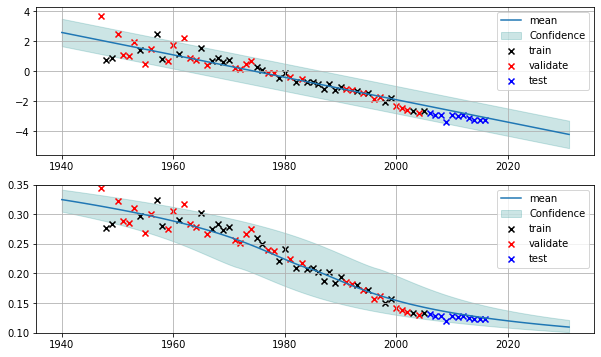

params:[-6.31639937e-02  1.24454122e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.017513143600588085 
 test_rmse: 0.007044221082943549



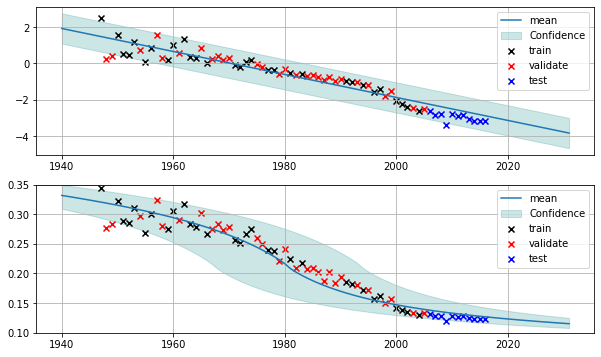

 47%|████▋     | 30/64 [00:33<00:38,  1.14s/it]

params:[-7.90704682e-02  1.55619392e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016875762690068716 
 test_rmse: 0.011923245800162598



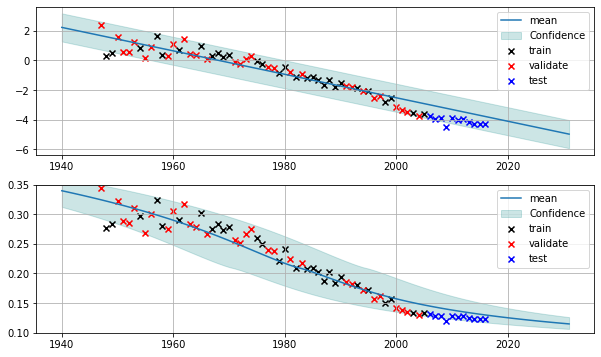

params:[-6.75427575e-02  1.32836834e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01976569103831817 
 test_rmse: 0.008947169631890559



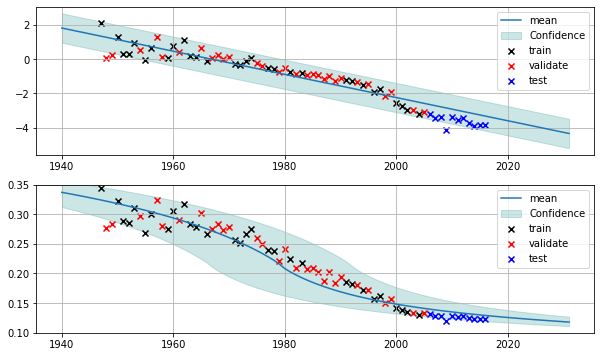

 48%|████▊     | 31/64 [00:34<00:39,  1.19s/it]

params:[-7.33319341e-02  1.45395170e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01578585562267301 
 test_rmse: 0.013093066929555724



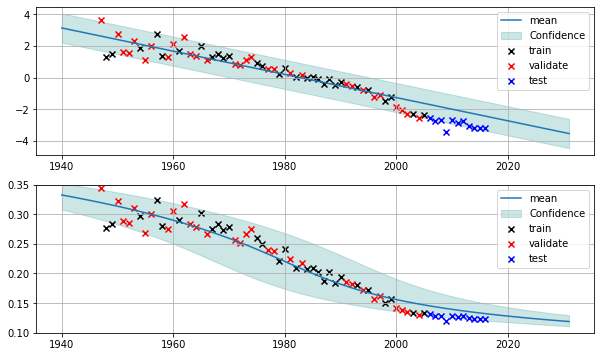

params:[-7.19664174e-02  1.42465029e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01947213685224926 
 test_rmse: 0.008004961482047691



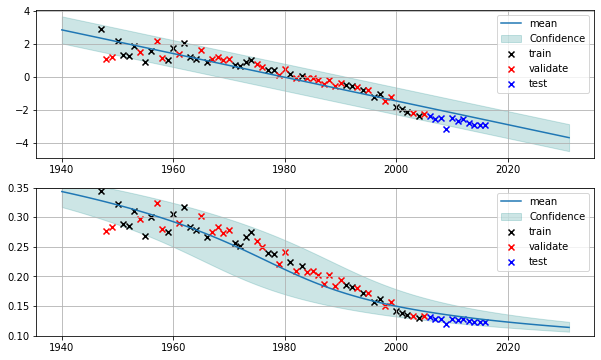

 50%|█████     | 32/64 [00:36<00:38,  1.22s/it]

params:[-4.54630044e-02  8.47445339e+01]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014445272852775488 
 test_rmse: 0.005890335253807173



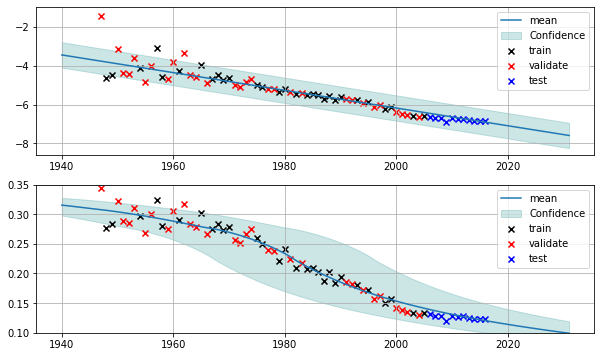

params:[-4.38417573e-02  8.14308948e+01]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01474040510405799 
 test_rmse: 0.004899323650801055



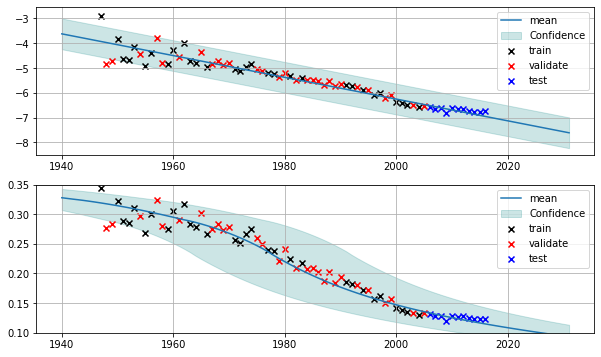

 52%|█████▏    | 33/64 [00:37<00:35,  1.15s/it]

params:[-5.64184010e-02  1.10544149e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014971758728886928 
 test_rmse: 0.011344403614399168



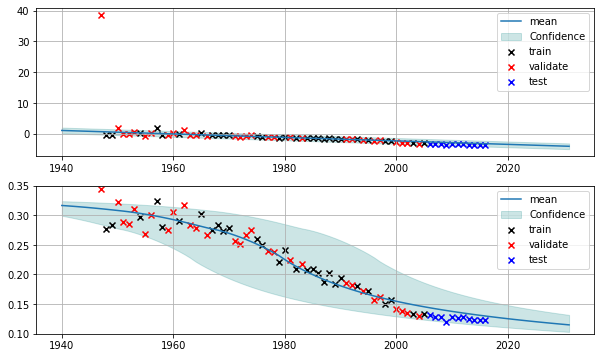

params:[-5.44196138e-02  1.06314082e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.018602082682625767 
 test_rmse: 0.005813307122368006



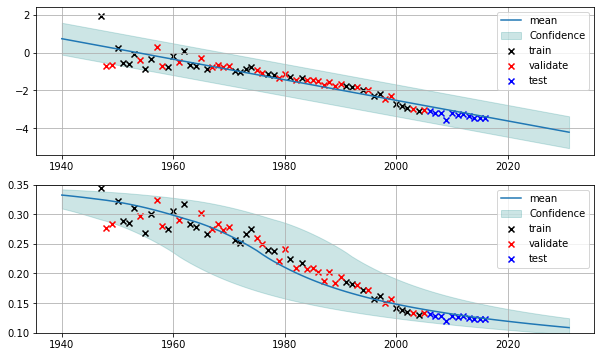

 53%|█████▎    | 34/64 [00:37<00:33,  1.10s/it]

params:[-5.73476913e-02  1.11388351e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015139976416191615 
 test_rmse: 0.011307685493099387



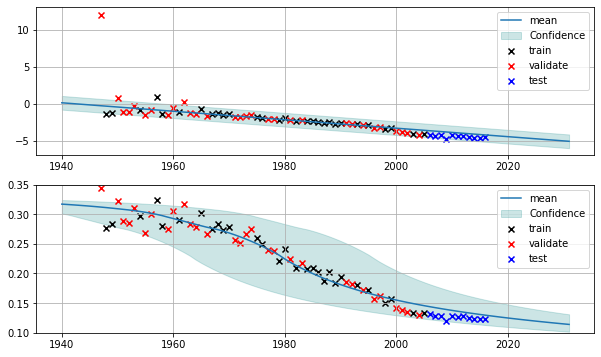

params:[-5.59393521e-02  1.08368068e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01923909385988645 
 test_rmse: 0.006173961200270641



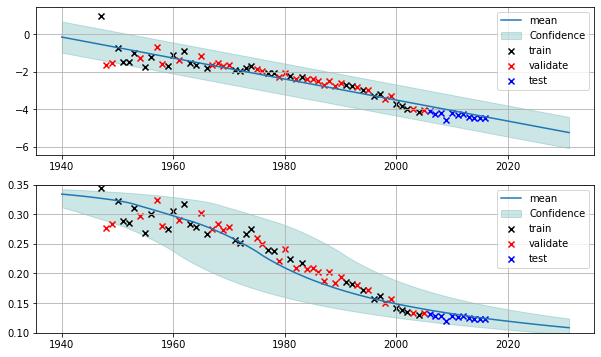

 55%|█████▍    | 35/64 [00:38<00:30,  1.06s/it]

params:[-5.69937349e-02  1.11562849e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014745428523481248 
 test_rmse: 0.009656027148489031



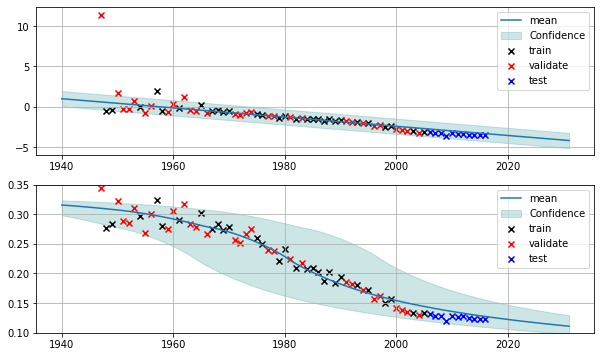

params:[-5.47897260e-02  1.06940701e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.017373693927824802 
 test_rmse: 0.004551605463906652



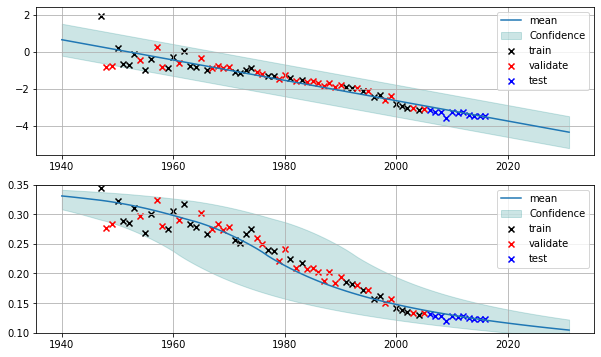

 56%|█████▋    | 36/64 [00:40<00:30,  1.10s/it]

params:[-6.32739827e-02  1.22244623e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014883172085779084 
 test_rmse: 0.010722654145054094



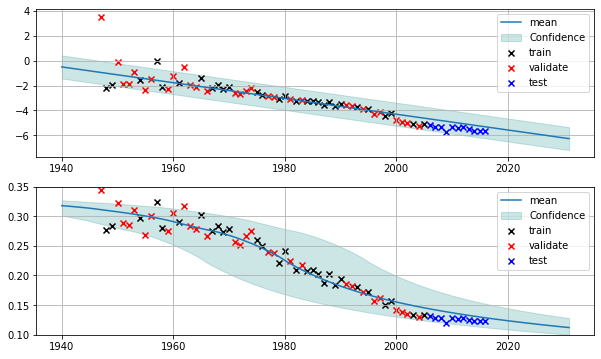

params:[-6.09294016e-02  1.17376086e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.018030535608843597 
 test_rmse: 0.005710690501839974



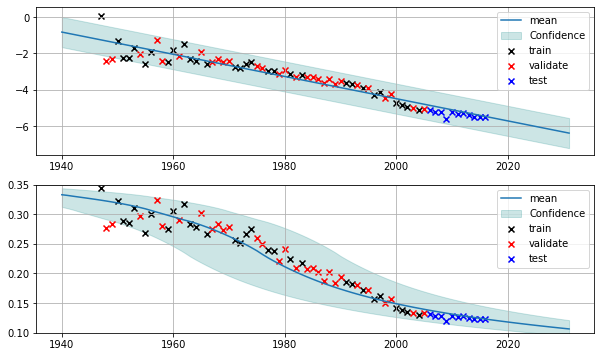

 58%|█████▊    | 37/64 [00:41<00:28,  1.07s/it]

params:[-5.41244023e-02  1.05626876e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014705243286639653 
 test_rmse: 0.00846451996558859



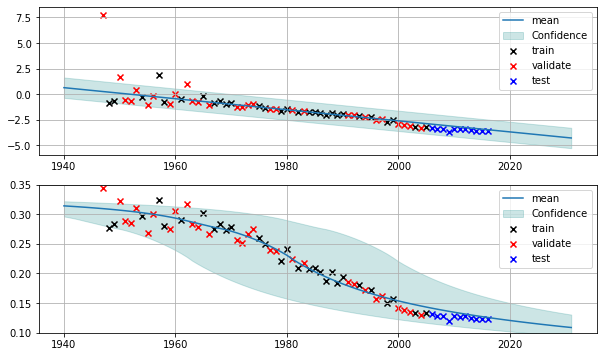

params:[-5.24416155e-02  1.02101175e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01726104270227449 
 test_rmse: 0.004091705035299038



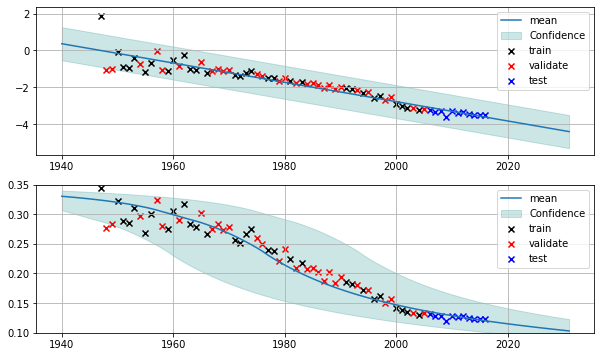

 59%|█████▉    | 38/64 [00:42<00:27,  1.05s/it]

params:[-6.01487862e-02  1.16966643e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.014732873717644977 
 test_rmse: 0.009396701779526553



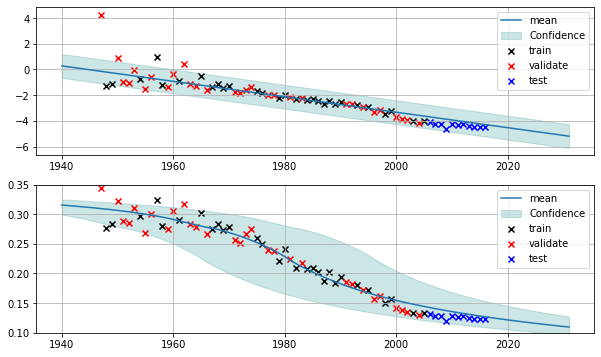

params:[-5.81777716e-02  1.12859787e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.017296077571091063 
 test_rmse: 0.004813814332053893



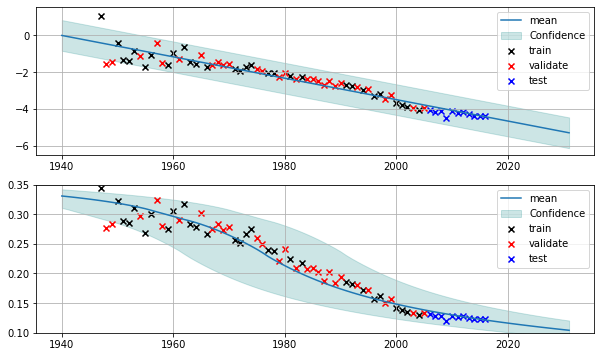

 61%|██████    | 39/64 [00:43<00:26,  1.05s/it]

params:[-6.02679344e-02  1.18115439e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014568349907460792 
 test_rmse: 0.008051486639783502



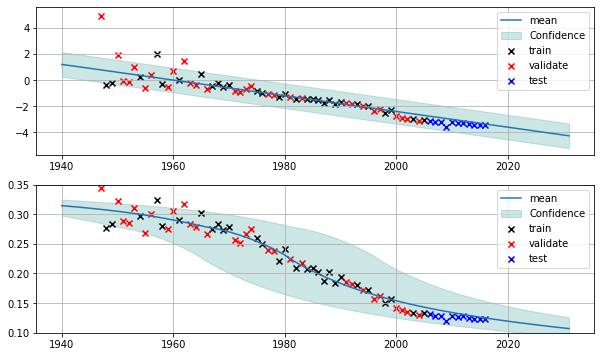

params:[-5.79825936e-02  1.13379397e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.0161161757286558 
 test_rmse: 0.004091495867308114



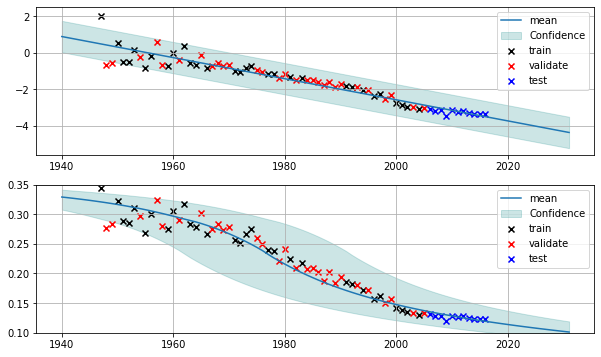

 62%|██████▎   | 40/64 [00:44<00:25,  1.05s/it]

params:[-6.14317058e-02  1.18007469e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015069799269436076 
 test_rmse: 0.011500529638386646



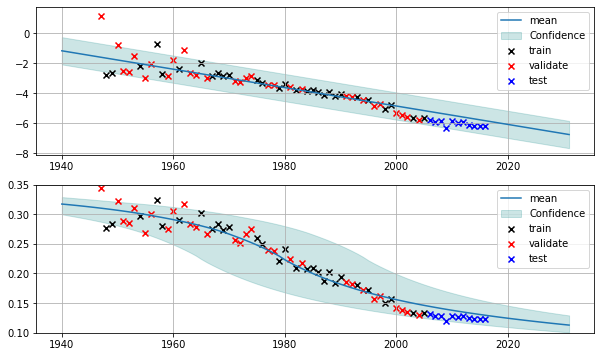

params:[-6.18794614e-02  1.18422497e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014774010244259256 
 test_rmse: 0.004528127782657473



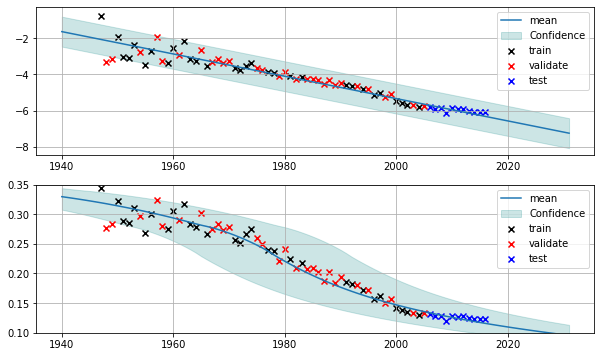

 64%|██████▍   | 41/64 [00:45<00:24,  1.07s/it]

params:[-5.35760565e-02  1.04737377e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.015136896811664224 
 test_rmse: 0.011564819518167518



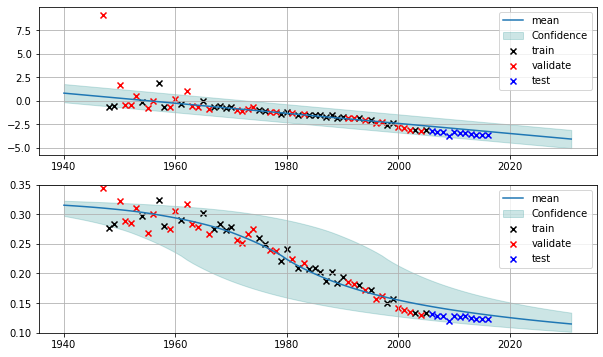

params:[-5.53709557e-02  1.07964161e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01585507401570229 
 test_rmse: 0.0039580563519868725



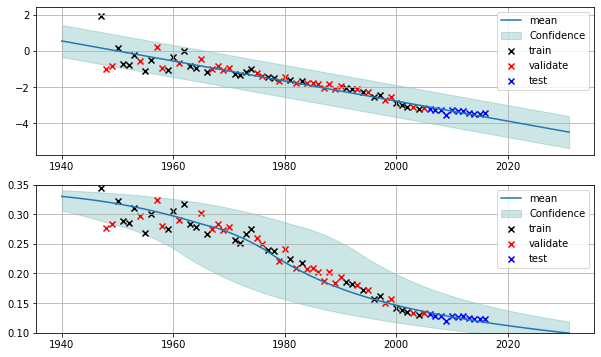

 66%|██████▌   | 42/64 [00:46<00:23,  1.07s/it]

params:[-5.78243135e-02  1.12427194e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015216699834034137 
 test_rmse: 0.011887671993347256



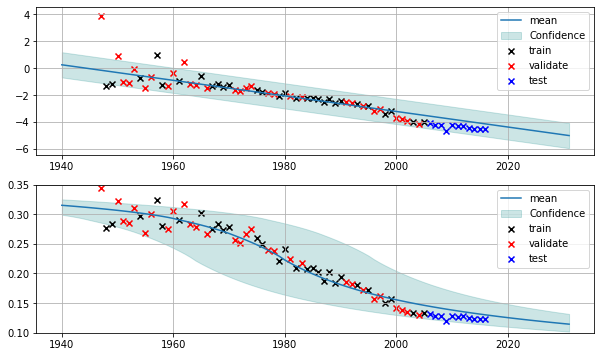

params:[-6.01753509e-02  1.16776470e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.016314700020922713 
 test_rmse: 0.0040880526912701765



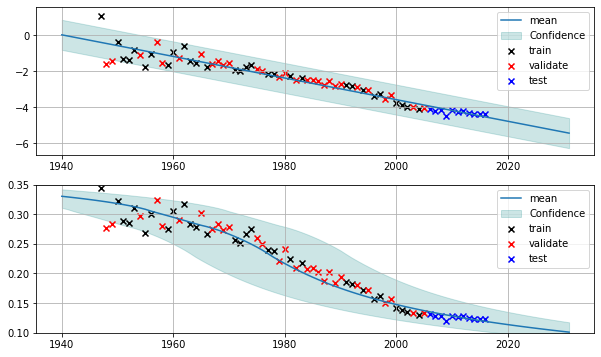

 67%|██████▋   | 43/64 [00:47<00:23,  1.10s/it]

params:[-5.79245998e-02  1.13512720e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01488652819533512 
 test_rmse: 0.010291151074346956



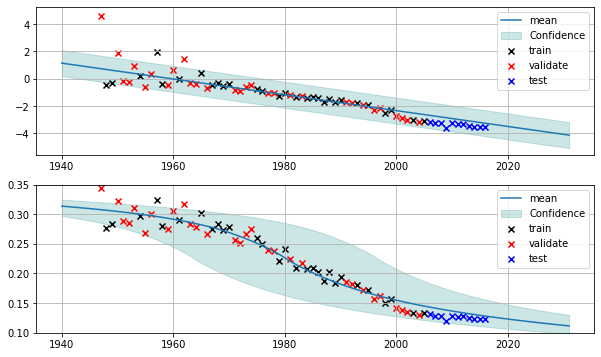

params:[-5.94078244e-02  1.16106462e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014634052550977154 
 test_rmse: 0.004749067813080504



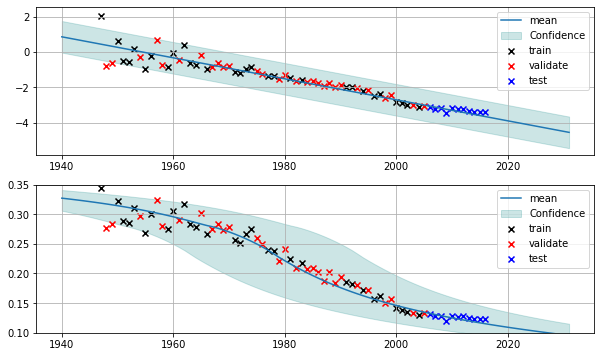

 69%|██████▉   | 44/64 [00:48<00:21,  1.08s/it]

params:[-6.44426470e-02  1.25031348e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015246239354134569 
 test_rmse: 0.01234825083605145



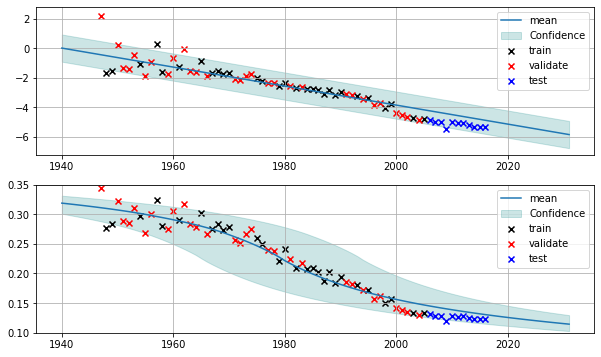

params:[-6.63185218e-02  1.28258796e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01524516580666446 
 test_rmse: 0.0041605508302969465



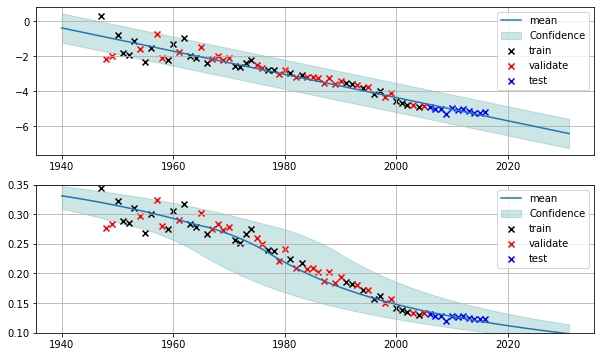

 70%|███████   | 45/64 [00:49<00:20,  1.08s/it]

params:[-5.79246426e-02  1.13512807e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014886526483030784 
 test_rmse: 0.01029114592564549



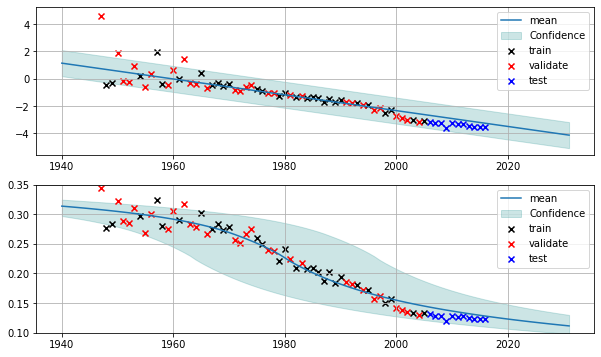

params:[-5.94077681e-02  1.16106352e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014634091988077686 
 test_rmse: 0.0047489965418185155



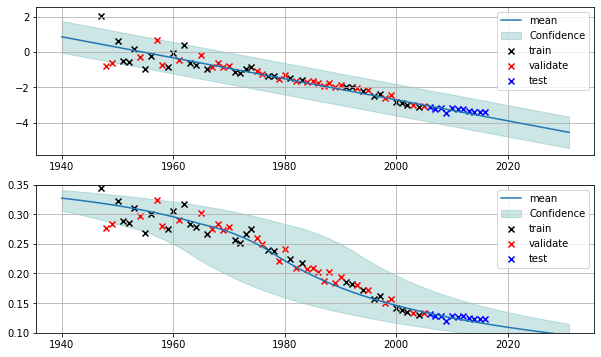

 72%|███████▏  | 46/64 [00:50<00:19,  1.08s/it]

params:[-6.38322044e-02  1.24776650e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015100604948211353 
 test_rmse: 0.011726664781111437



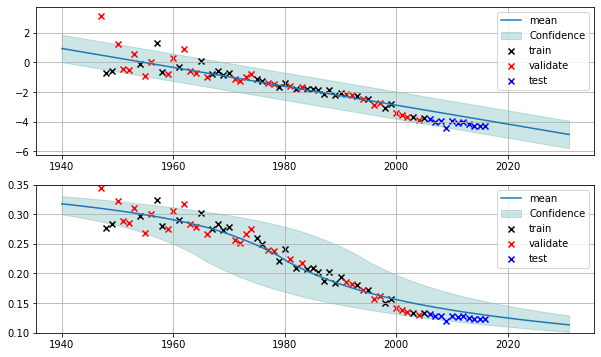

params:[-6.59980801e-02  1.28610614e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015084357699788825 
 test_rmse: 0.004184542938795039



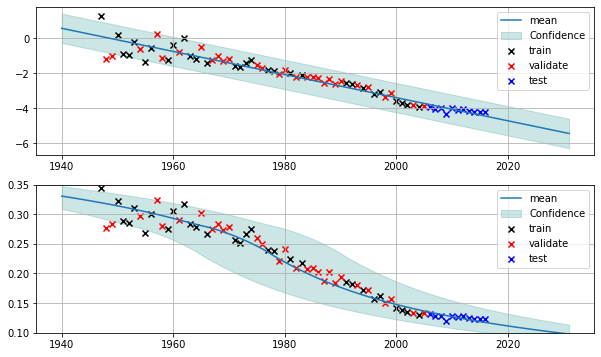

 73%|███████▎  | 47/64 [00:51<00:17,  1.05s/it]

params:[-6.48227119e-02  1.27701340e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014918840698725545 
 test_rmse: 0.010942755782053643



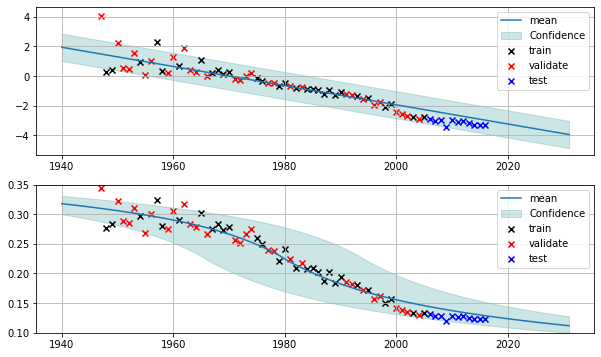

params:[-6.33759912e-02  1.24572136e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.0167814922339302 
 test_rmse: 0.0049651405712377705



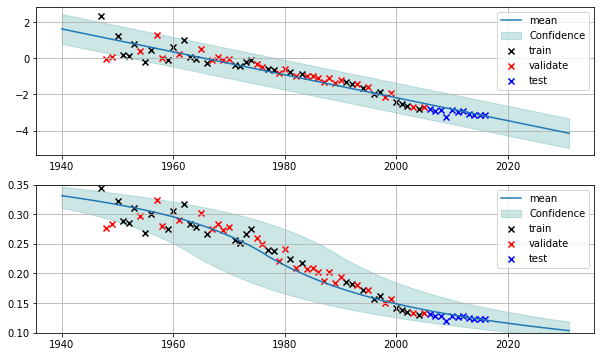

 75%|███████▌  | 48/64 [00:52<00:16,  1.05s/it]

params:[-6.07453937e-02  1.15944772e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01450799968744652 
 test_rmse: 0.00725139294730178



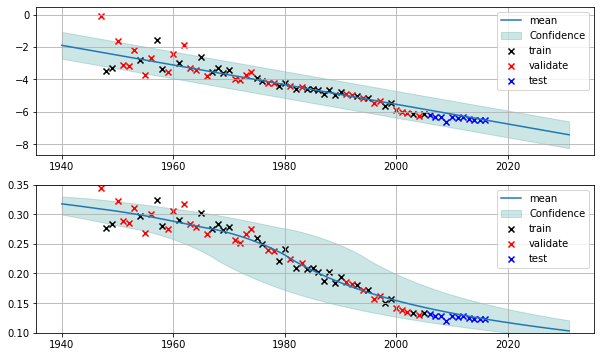

params:[-5.78883097e-02  1.10141136e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015428553279204641 
 test_rmse: 0.00424114307527797



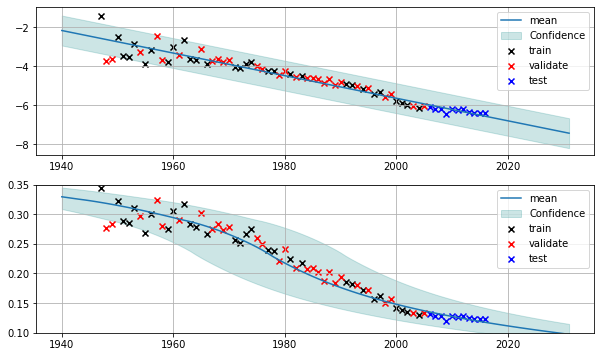

 77%|███████▋  | 49/64 [00:53<00:15,  1.04s/it]

params:[-5.69936069e-02  1.11562588e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014745433459899433 
 test_rmse: 0.009656029530280304



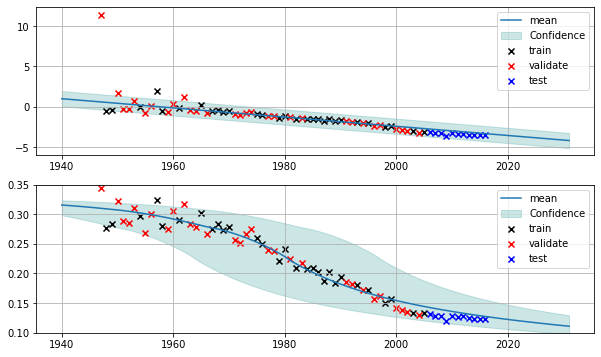

params:[-5.47897210e-02  1.06940689e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.017373671641112746 
 test_rmse: 0.0045515877057909675



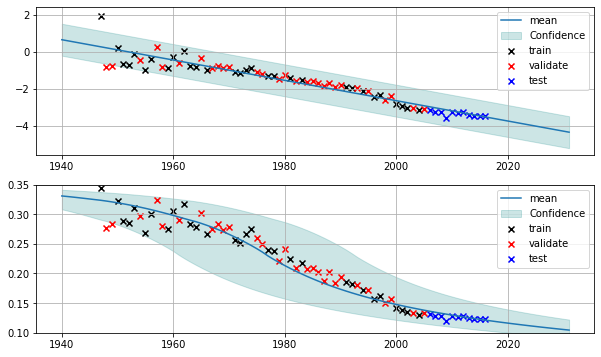

 78%|███████▊  | 50/64 [00:54<00:14,  1.04s/it]

params:[-6.01487720e-02  1.16966618e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.014732877761873838 
 test_rmse: 0.009396732546220856



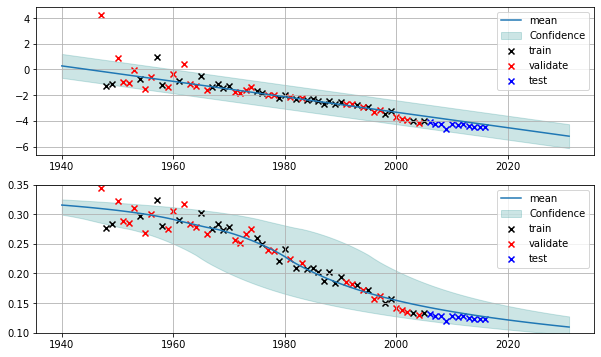

params:[-5.81777454e-02  1.12859736e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.017296061007420455 
 test_rmse: 0.004813801271731921



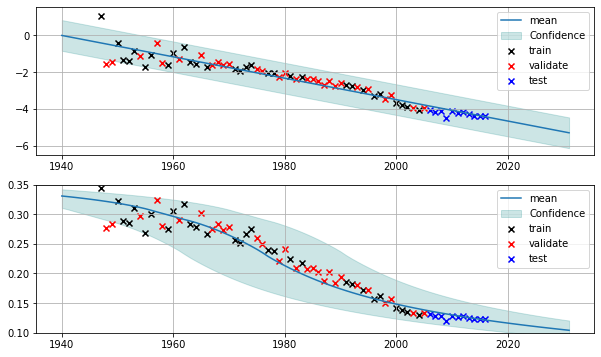

 80%|███████▉  | 51/64 [00:56<00:13,  1.07s/it]

params:[-6.02679043e-02  1.18115381e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014568353596707778 
 test_rmse: 0.008051535838747537



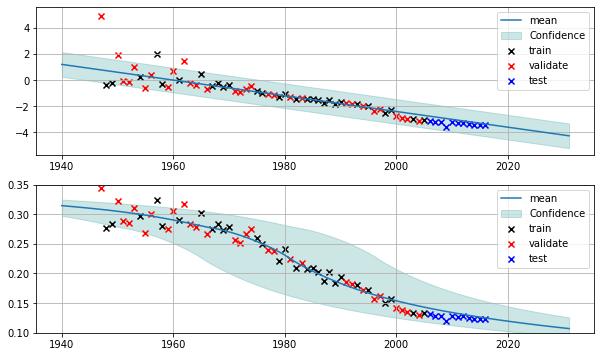

params:[-5.79827424e-02  1.13379696e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01611634595282071 
 test_rmse: 0.004091564675491563



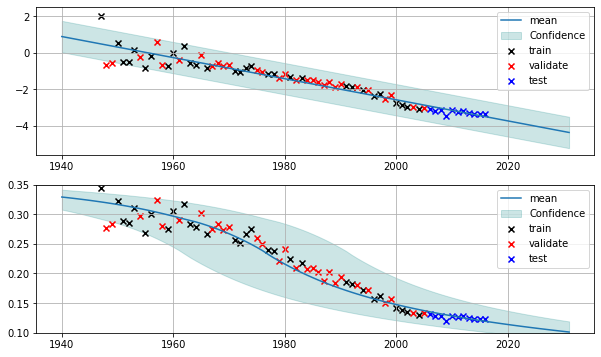

 81%|████████▏ | 52/64 [00:57<00:12,  1.07s/it]

params:[-6.44426377e-02  1.25031330e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015246241315005266 
 test_rmse: 0.012348260988030383



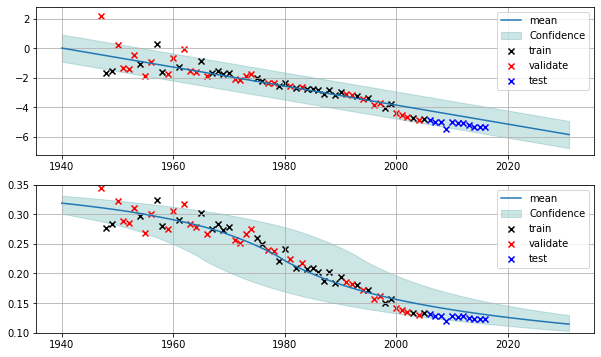

params:[-6.63185288e-02  1.28258810e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.015245165908302515 
 test_rmse: 0.004160551919459666



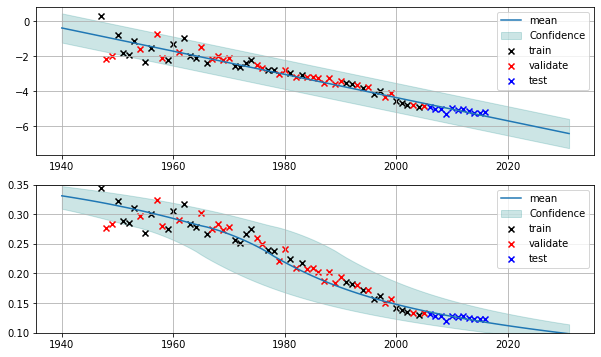

 83%|████████▎ | 53/64 [00:58<00:11,  1.07s/it]

params:[-5.79246051e-02  1.13512732e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01488652897598963 
 test_rmse: 0.010291161469483655



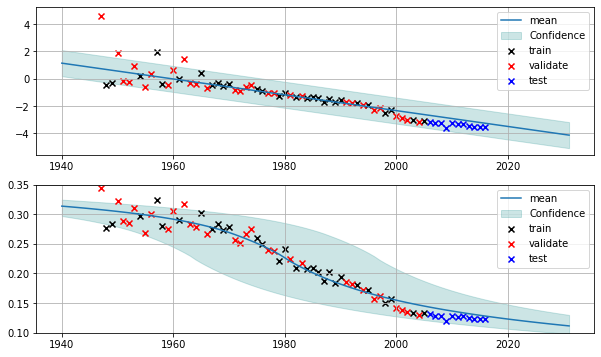

params:[-5.94077707e-02  1.16106358e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.01463409173937945 
 test_rmse: 0.004748999964116294



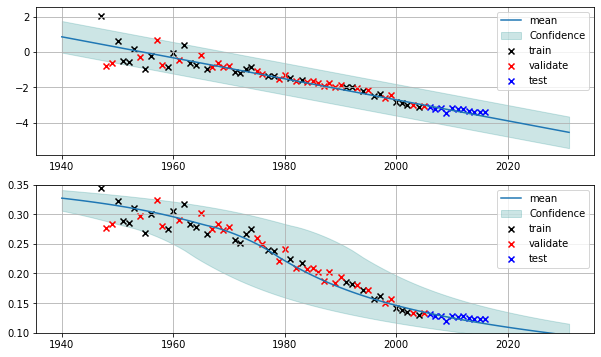

 84%|████████▍ | 54/64 [00:59<00:10,  1.09s/it]

params:[-6.38321890e-02  1.24776622e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015100610116159024 
 test_rmse: 0.011726686742332893



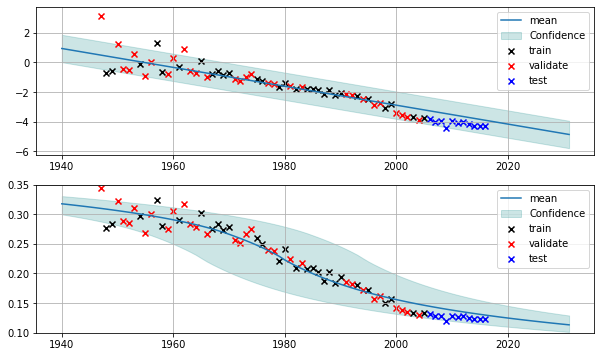

params:[-6.59979985e-02  1.28610454e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015084365767674482 
 test_rmse: 0.004184531327768012



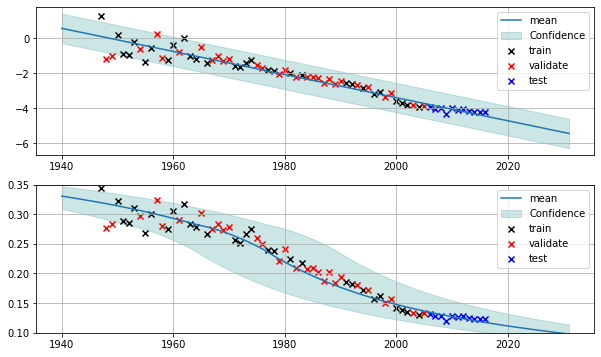

 86%|████████▌ | 55/64 [01:00<00:09,  1.08s/it]

params:[-6.48227195e-02  1.27701356e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014918836482086051 
 test_rmse: 0.010942739639754326



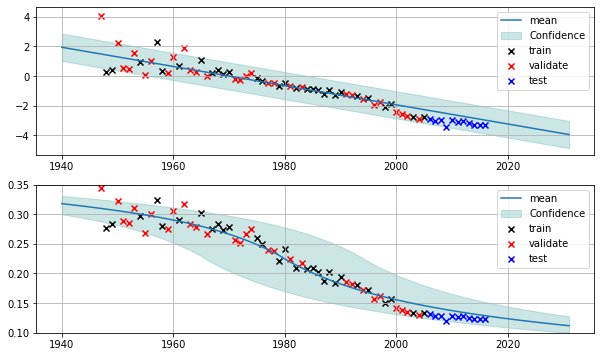

params:[-6.33759508e-02  1.24572060e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016781467152217098 
 test_rmse: 0.004965117917423851



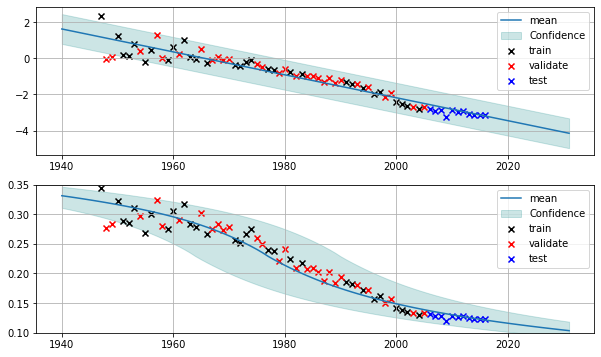

 88%|████████▊ | 56/64 [01:01<00:08,  1.07s/it]

params:[-7.06565478e-02  1.36659376e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014643366193026643 
 test_rmse: 0.00891555680075394



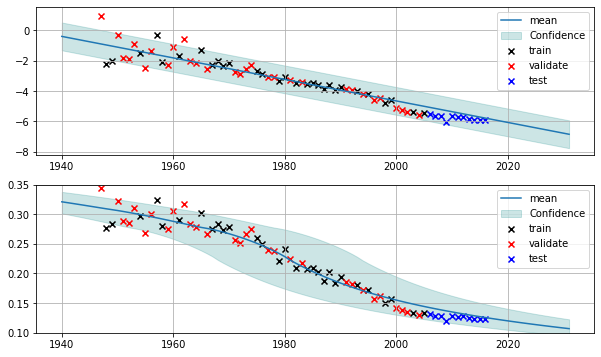

params:[-6.68979240e-02  1.29036765e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.01632945829302039 
 test_rmse: 0.0046694615734567116



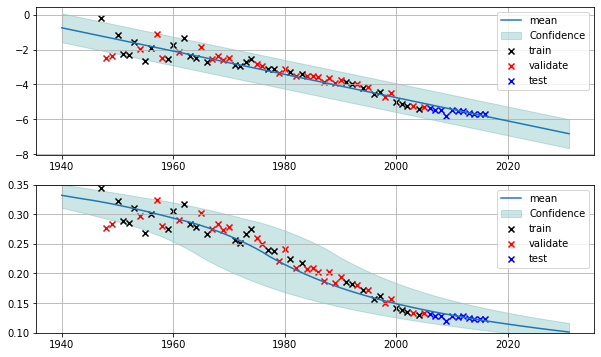

 89%|████████▉ | 57/64 [01:02<00:07,  1.07s/it]

params:[-6.02679212e-02  1.18115414e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.0145683527512316 
 test_rmse: 0.008051526104782346



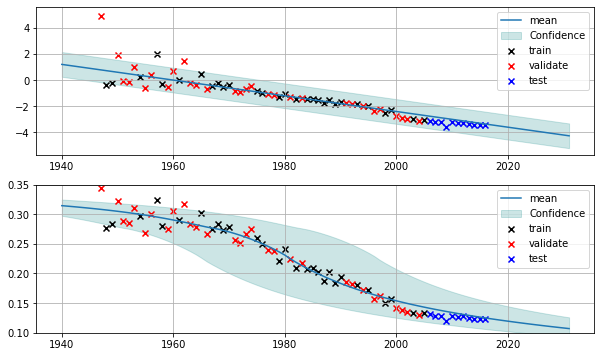

params:[-5.79827496e-02  1.13379711e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016116344803335503 
 test_rmse: 0.004091563693572882



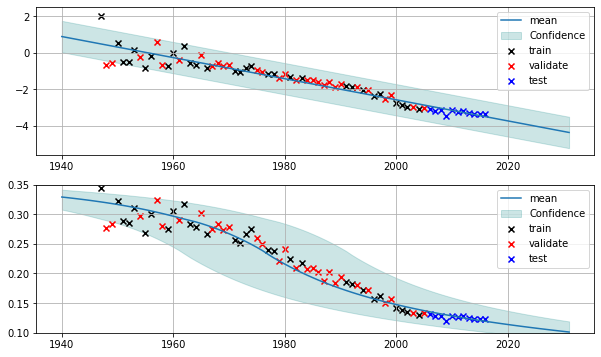

 91%|█████████ | 58/64 [01:03<00:06,  1.07s/it]

params:[-6.38321940e-02  1.24776629e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015100608886572138 
 test_rmse: 0.01172669742574716



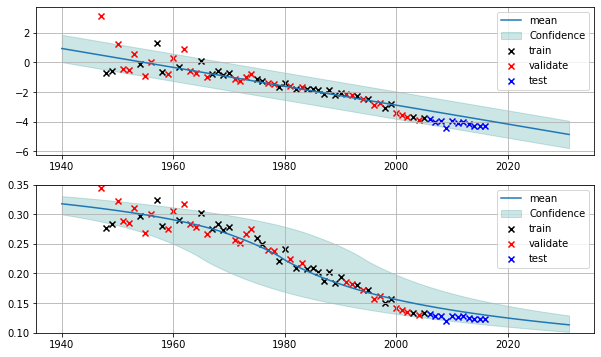

params:[-6.59981693e-02  1.28610790e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.015084348615618276 
 test_rmse: 0.00418453468261053



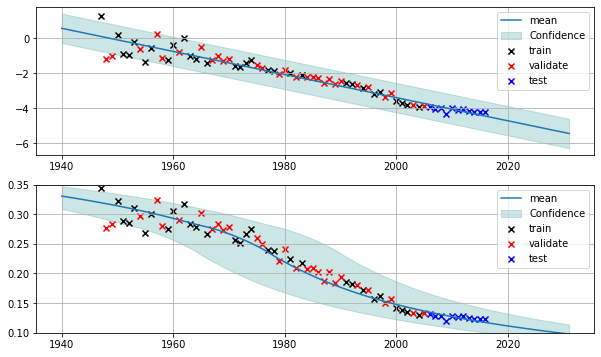

 92%|█████████▏| 59/64 [01:04<00:05,  1.04s/it]

params:[-6.48226833e-02  1.27701284e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.014918839896550278 
 test_rmse: 0.010942760482654097



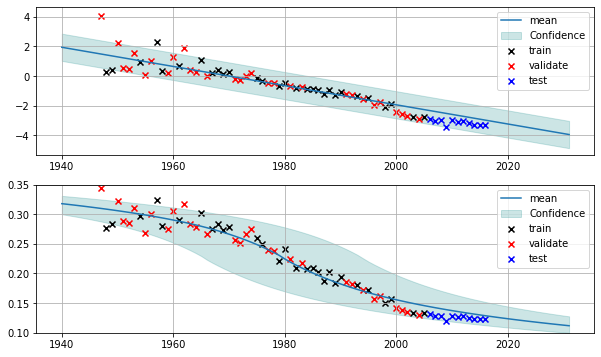

params:[-6.33760042e-02  1.24572162e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.016781488776299824 
 test_rmse: 0.004965135403796865



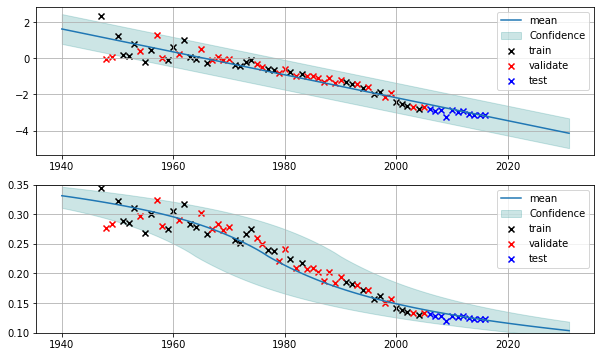

 94%|█████████▍| 60/64 [01:05<00:04,  1.09s/it]

params:[-7.26542844e-02  1.41672325e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.014693902249702104 
 test_rmse: 0.009798621597957267



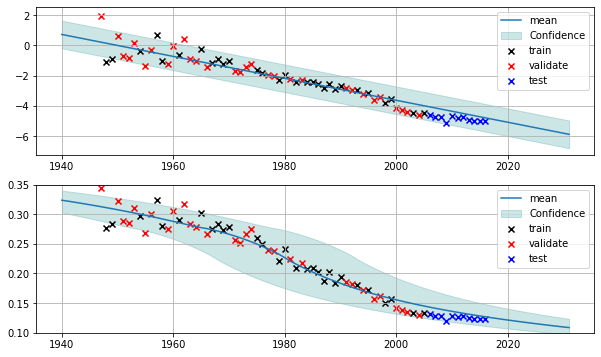

params:[-6.91819809e-02  1.34621678e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.017101493635542114 
 test_rmse: 0.00536651001398305



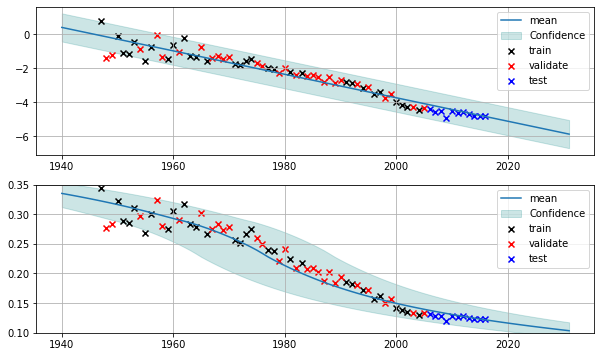

 95%|█████████▌| 61/64 [01:06<00:03,  1.10s/it]

params:[-6.48226908e-02  1.27701299e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.014918839783977116 
 test_rmse: 0.010942758533264032



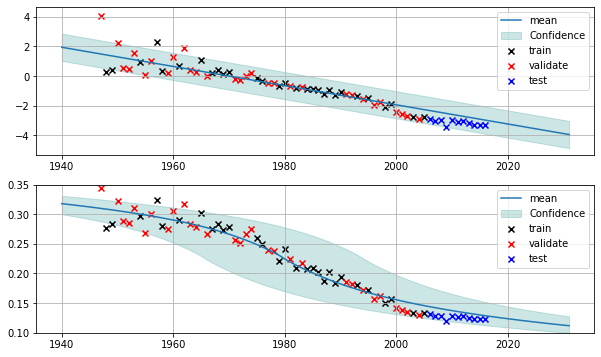

params:[-6.33761261e-02  1.24572400e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.016781509849568558 
 test_rmse: 0.004965155367336509



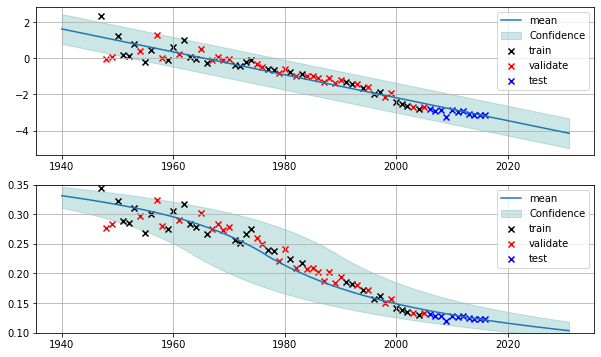

 97%|█████████▋| 62/64 [01:07<00:02,  1.11s/it]

params:[-6.94218912e-02  1.36457612e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01563424448800212 
 test_rmse: 0.013448684827608444



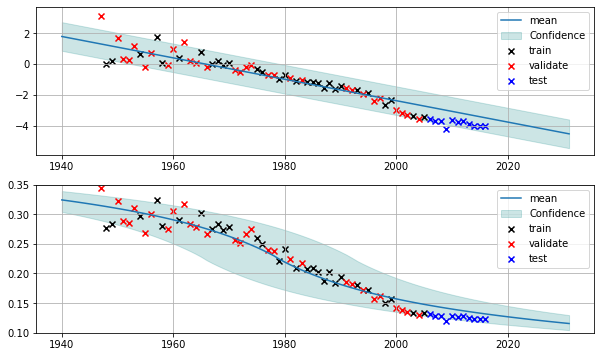

params:[-6.85063571e-02  1.34387422e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.01881023890989287 
 test_rmse: 0.006839951677662285



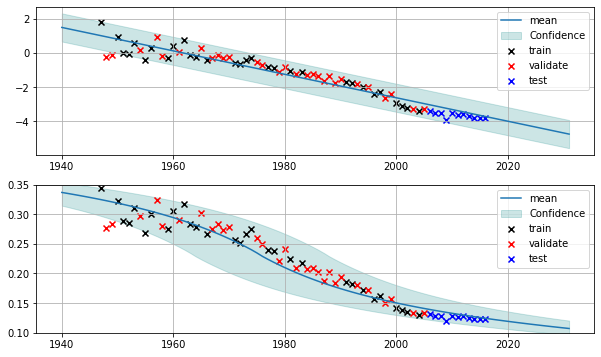

 98%|█████████▊| 63/64 [01:09<00:01,  1.13s/it]

params:[-7.30408840e-02  1.44527898e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.015749194928931117 
 test_rmse: 0.011769434268321303



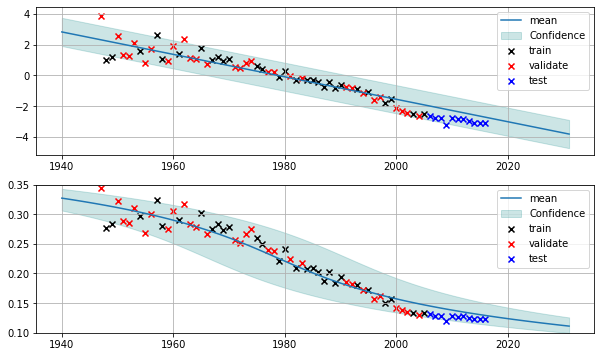

params:[-7.08901222e-02  1.40038753e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.01830576289389326 
 test_rmse: 0.00595287051209087



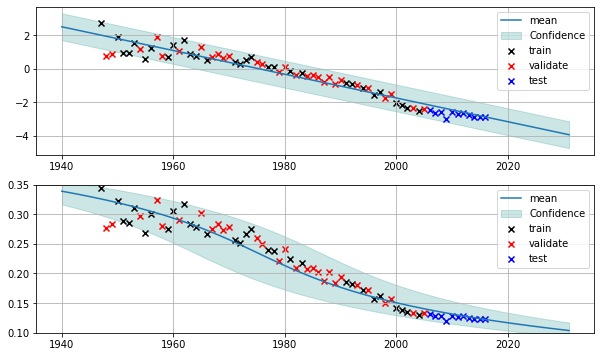

100%|██████████| 64/64 [01:10<00:00,  1.11s/it]


In [16]:
result = grid_search(cwgp_regression, x_tv, y_tv, {"c":6,"n":[1],"transformations":["box_cox","sa"]},
                    cv=True, n_splits=2, shuffle=True,
                     x_test=x_test,y_test=y_test,ylim=age_lim,
                     mean_func=poly, init_params=(1,-0.1),
                     kernel = GPy.kern.RBF(1),
                    val_rmse_list=val_rmse_list, test_rmse_list=test_rmse_list,
                    )

In [17]:
import json

result_json = json.loads(json.dumps(result))

In [18]:
result_df = pd.DataFrame.from_records(result_json).T

In [19]:
result_df.loc[:,result_df.columns[0]].apply(pd.Series)

0         1
0   0.016927  0.007872
1   0.016794  0.003536
10  0.014766  0.009370
11  0.014722  0.008749
12  0.016752  0.012727
..       ...       ...
62  0.015634  0.013449
63  0.015749  0.011769
7   0.016743  0.003391
8   0.016367  0.002780
9   0.014768  0.009284

[64 rows x 2 columns]

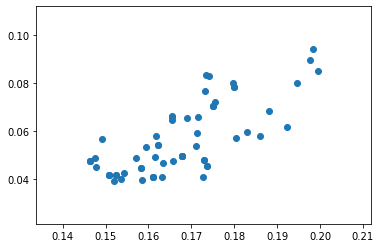

In [23]:
plt.scatter(result_df.loc[:,result_df.columns[1]].apply(pd.Series).loc[
    :,0]*10,result_df.loc[:,result_df.columns[1]].apply(pd.Series).loc[:,1]*10)